## Assignment 9: Apply GBDT and RF to Amazon reviews dataset. [M]

Given Dataset consists of reviews of fine foods from amazon. Reviews describe 
* (1) product and user information,
* (2) ratings
* (3) a plain text review.

Here, **GBDT(Gradient Boosting Decision Tree) and RF(Random Forest) algorithm** is applied on amazon reviews datasets to predict whether a review is positive or negative.

Procedure to execute the above task is as follows:

* **Step1: Data Pre-processing is applied on given amazon reviews data-set.**


* **Step2: Time based splitting on train and test datasets.**


* **Step3: Apply  Feature generation techniques(BOW,TF-IDF,avg w2v,tfidfw2v)** 

  
* **Step4: Apply GBDT(Gradient Boosting Decision Tree) algorithm using each technique.**


* **Step5: Apply RF(Random Forest) algorithm using each technique.**


* **Step6: To find Number of Base learners(m) using gridsearch cross-validation in case of RF(Random Forest) algorithm .**


* **Step7: To find Number of Base learners(m),depth,learning rate(v) using gridsearch cross-validation in case of RF(Random Forest) algorithm.**

         

## Objective:

* **To classify given reviews (positive (Rating of 4 or 5) & negative (rating of 1 or 2)) using GBDT(Gradient Boosting Decision Tree) and RF(Random Forest) algorithm .**







In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import re
import math
import sqlite3
import pandas as pd
import numpy as np
import pickle
import graphviz 
import pydot
# modules for text processing
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

from xgboost.sklearn import XGBClassifier
from xgboost import plot_tree
import xgboost as xgb


from sklearn.externals import joblib
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

#import scikitplot.metrics as skplt
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer


# knn modules
# train-split data,accuracy-score,cross-validation modules
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score

from collections import Counter


from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV
from tqdm import tqdm
import os
from sklearn.decomposition import TruncatedSVD
import pytablewriter


In [2]:
try:
    from StringIO import StringIO
except ImportError:
    
    from io import StringIO

In [3]:
import zipfile
archive = zipfile.ZipFile('/floyd/input/pri/Reviews.zip', 'r')
csvfile = archive.open('Reviews.csv')

In [4]:
# Reading CSV file and printing first five rows 
amz = pd.read_csv(csvfile ) # reviews.csv is  dataset file
print(amz.head())

   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1 

In [5]:
# dimensions of dataset and columns name

print(amz.shape) 
#print(amz1.shape)
print(amz.columns)

(568454, 10)
Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')


The amazon reviews datafile contains 568454 rows of entry and 10 columns.For given objective, processing of data is necessary."Score" and "text" columns is processed for required result.

##### Given reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating. If score is equal to 3,it is considered as neutral score.

In [6]:
# Processing
#Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.

def score_part(x):
    if x < 3:
        return 'negative'
    return 'positive'

actualScore = amz['Score']
#print(actualScore)
New_score = actualScore.map(score_part)
#print(New_score)
amz['Score']=New_score

# If score is equal to 3,it is considered as neutral score.

    






In [7]:
print(amz.shape)
amz.head(5)


(568454, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


#### Data Pre-processing on raw data:

Every datasets contains some unwanted data.Raw data is preprocessed by removing duplication.


In [8]:
#Processing of ProductId
#Sorting data according to ProductId in ascending order
sorted_data=amz.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
#sorted_data.head() # printing sorted data
# To check the duplications in raw data
dupli=sorted_data[sorted_data.duplicated(["UserId","ProfileName","Time","Text"])]
print(dupli.head(5))
# Remove Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(amz['Id'].size*1.0)*100
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

            Id   ProductId          UserId  \
171222  171223  7310172001   AJD41FBJD9010   
171153  171154  7310172001   AJD41FBJD9010   
171151  171152  7310172001   AJD41FBJD9010   
217443  217444  7310172101  A22FICU3LCG2J1   
217444  217445  7310172101  A1LQV0PSM04DWI   

                                         ProfileName  HelpfulnessNumerator  \
171222  N. Ferguson "Two, Daisy, Hannah, and Kitten"                     1   
171153  N. Ferguson "Two, Daisy, Hannah, and Kitten"                     0   
171151  N. Ferguson "Two, Daisy, Hannah, and Kitten"                     0   
217443                                      C. Knapp                     1   
217444                                 B. Feuerstein                     1   

        HelpfulnessDenominator     Score        Time  \
171222                       1  positive  1233360000   
171153                       0  positive  1233360000   
171151                       0  positive  1233360000   
217443                       1

positive    336824
negative     57107
Name: Score, dtype: int64

List of total counts Postive score and Negative score ==> [336824, 57107]


Text(0.5,1,'Total counts of Postive score and Negative score ')

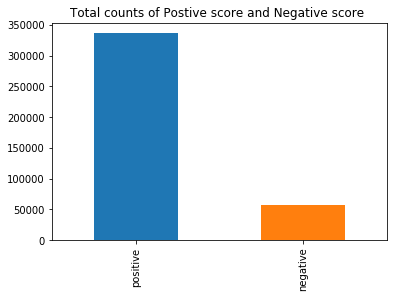

In [9]:
a=final['Score'].value_counts().tolist()
print('List of total counts Postive score and Negative score ==>',a)
final['Score'].value_counts().plot(kind='bar')
plt.title('Total counts of Postive score and Negative score ')


#### observations
* The positive reviews is greater than negative reviews.It makes data imbalanced.
* From the bar plot ,it is seen that sampled datasets of review is imbalnced.


# Text Preprocessing:

In [10]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [11]:
 
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>$< /><')
    #cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned


cleaning html tags like" <.*?>" and punctuations like " r'[?|!|\'|"|#]',r''" from senetences

In [12]:
#final = final.sample(frac=0.04,random_state=None)
#print(final.shape)

In [13]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase.

'''Pre processing of text data:It is cleaning and flitering text'''
i=0
str1=' '
global final_string
final_string=[]
all_positive_words=[] 
all_negative_words=[] 
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")

    final_string.append(str1)
    i+=1
#print('all_positive_words =',len(all_positive_words))
#print('all_negative_words =',len(all_negative_words))

# Finding most frequently occuring Positive and Negative words 

freq_positive=nltk.FreqDist(all_positive_words)

freq_negative=nltk.FreqDist(all_negative_words)

#print("\nMost Common Positive Words : ",freq_positive.most_common(20))

#print("\nMost Common Negative Words : ",freq_negative.most_common(20))




##### Dumping and loading  Pre processing of text data in pickle file 

In [14]:
pickle_path_final_string='final_string.pkl'
final_string_file=open(pickle_path_final_string,'wb')
pickle.dump(final_string,final_string_file)
final_string_file.close()

In [12]:
pickle_path_final_string='final_string.pkl'
final_string_unpkl=open(pickle_path_final_string,'rb')
final_string=pickle.load(final_string_unpkl)

In [13]:

final['CleanedText']=final_string
#adding a column of CleanedText which displays the data after pre-processing of the review 
Pre_Process_Data = final[['CleanedText','Score','Time']] 

X_Text=Pre_Process_Data ['CleanedText']

Y_Score =Pre_Process_Data ['Score'] # positive or negative score
print('\nPre_Process_Text_Data  X_Text=',X_Text.shape)
print('\nPre_Process_Score_Data Y_Score=',Y_Score.shape)



Pre_Process_Text_Data  X_Text= (393931,)

Pre_Process_Score_Data Y_Score= (393931,)


In [14]:
# postive and negtive reviews from original datasets of amazon
pos_final = Pre_Process_Data[Pre_Process_Data .Score == 'positive']# postive reviews
pos_final = pos_final.sample(frac=0.3)
print(pos_final.Score.value_counts())

neg_final = Pre_Process_Data [Pre_Process_Data .Score == 'negative'] # negative reviews
print(neg_final.Score.value_counts())

positive    101047
Name: Score, dtype: int64
negative    57107
Name: Score, dtype: int64


In [15]:
final_pos_neg = pd.concat([pos_final,neg_final],axis=0)
print(len(final_pos_neg))
print(type(final_pos_neg))
#print('final_pos_neg=',final_pos_neg['Score'])

158154
<class 'pandas.core.frame.DataFrame'>


In [16]:
print(final_pos_neg.columns)

Index(['CleanedText', 'Score', 'Time'], dtype='object')


### Splitting Training and Testing dataset

In [17]:
# splitting training and testing dataset (Time based splitting)

X1 = final_pos_neg[['CleanedText','Time']].sort_values('Time',axis=0).drop('Time',axis=1)
#40k data sample
X=X1[:40000]

print(X.shape)
Y1 = final_pos_neg[['Score','Time']].sort_values('Time',axis=0).drop('Time',axis=1)
#40k data sample
Y=Y1[:40000]
print(Y.shape)
## 70 % of data

X_train_data ,X_test_data,Y_train_data,Y_test_data  = train_test_split(X,
                                                      Y.values.ravel(),
                                                                       
                                                    test_size=0.3,shuffle=False)



print('X_train_data ',X_train_data.shape)

print('X_test_data ',X_test_data.shape )

print('Y_train_data ',Y_train_data .shape)

print('Y_test_data ',Y_test_data .shape)



(40000, 1)
(40000, 1)
X_train_data  (28000, 1)
X_test_data  (12000, 1)
Y_train_data  (28000,)
Y_test_data  (12000,)


In [18]:

Y_new = Y['Score'].map(lambda x: 1 if x == 'positive' else 0).values.ravel()
# Y train and Test for sparse datasets

y_train_new,y_test_new = train_test_split(Y_new,test_size=0.3,shuffle=False)
print('y_train_new ',y_train_new.shape)

print('y_test_new ',y_test_new .shape)


y_train_new  (28000,)
y_test_new  (12000,)


In [19]:
Train_data=y_train_new
print(Train_data.shape)

(28000,)


#  Optimal Base_learners for Random Forests

In [20]:
 # Time seris splitting Cross-Validation
    
tscv = TimeSeriesSplit(n_splits=3)

In [21]:
n_estimators=[100,150,200]
Learning_rate=[0.1,0.001,0.6]
Max_depth= [8,14,18]

In [22]:
# Optimal_Base_learners is function to calculate the optimal Base_learners 

def Optimal_Base_learners(X_train,y_train):
    
    parameter_grid = dict(max_depth = Max_depth,n_estimators=n_estimators,
                          max_features=['sqrt', 'log2'],
                  criterion=['gini',])
    
           
    random_forest = RandomForestClassifier( n_jobs =-1,
                               class_weight='balanced' ,
                               bootstrap=True,
                               oob_score = True)

    RF_clf = GridSearchCV(estimator=random_forest,
                          param_grid=parameter_grid, 
                          cv=tscv, n_jobs=-1)

    RF_clf.fit(X_train,y_train)
    optimal_estim=RF_clf.best_estimator_
    print("optimal_estim==",optimal_estim)
    global optimal_parameters_RF   

    optimal_parameters_RF  =RF_clf.best_params_

    scores = cross_val_score(RF_clf, X_train, y_train, cv=tscv, n_jobs=-1)
    
       
    print('Mean of score:', np.mean(scores))
    print('Variance of scores:', np.var(scores))
    MSE = [1 - x for x in scores]
   
    print('\nThe optimal Best_parameters for Random Forest is === ',optimal_parameters_RF)
     # plot misclassification error vs Number_Base_learners of Random Forests
    fig4 = plt.figure( facecolor='c', edgecolor='k')
    fig4.suptitle('Number_Base_learners vs CV Scores',
                  fontsize=12)
   
    plt.plot(n_estimators, MSE, color='green', marker='o', linestyle='dashed',
                linewidth=2, markersize=12)

    for xy in zip(n_estimators, np.round(MSE,3)):
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
   
    plt.xlabel('Number of Base learners')
    plt.ylabel('CV Scores')
    plt.show()

    print("the misclassification error for each Base learners is : ", np.round(MSE,5))

    



####  Base_learners with different depth size

In [23]:
# clf_perform_depth is function
#to calculate the Base_learners with different depth size
def clf_perform_depth(clf,X_train,y_train):
  
    # Parameters for model
    parameter_grid = dict(max_depth = Max_depth,
                          n_estimators=n_estimators)  
          
   
    clf_CV = GridSearchCV(estimator=clf,
                          param_grid=parameter_grid,
                          cv=tscv, n_jobs=-1)
    
    clf_CV_result=clf_CV.fit(X_train,y_train)
       
    means =clf_CV_result.cv_results_['mean_test_score']
    print(means)
   
    
    
    # plot results
    scores = np.array(means).reshape(len(Max_depth), len(n_estimators))
    fig41 = plt.figure( facecolor='c', edgecolor='k')
    fig41.suptitle('Number_Base_learners vs CV Scores',
                  fontsize=12)   
    for i, value in enumerate(Max_depth):
        print(Max_depth)
        plt.plot(n_estimators, scores[i],
                 linewidth=2, markersize=12,
                 label='depth: ' + str(value))
    plt.legend()
    plt.grid()
  
    plt.xlabel('n_estimators')
    plt.ylabel('CV Scores')
    
    

#  Optimal Parameters for GBDT Algorithm

In [24]:
# Optimal_BL_Depth_LR is function to calculate the optimal Base_learners,Depth Size,Learning Rate
def Optimal_BL_Depth_LR(X_train,y_train):
    parameter_grid = dict(learning_rate=Learning_rate,
                          max_depth = Max_depth,
                           n_estimators=n_estimators)  
                      
        

    GBDT_model = XGBClassifier()

    GBDT_clf = GridSearchCV(estimator=GBDT_model,
                            param_grid=parameter_grid,
                        n_jobs=-1,
                        cv=tscv)

    GBDT_clf_result=GBDT_clf.fit(X_train,y_train)
    global Optimal_param_GBDT 
    Optimal_estim_GBDT =GBDT_clf_result.best_estimator_
    Optimal_param_GBDT =GBDT_clf_result.best_params_
    print("Optimal_estim_GBDT===",Optimal_estim_GBDT)


    scores = cross_val_score(GBDT_clf_result, X_train, y_train, cv=tscv, n_jobs=-1)
   
    MSE =[1 - x for x in scores]
   
    print('\nThe optimal parameter for GBDT is ===' ,Optimal_param_GBDT )
    fig4 = plt.figure( facecolor='c', edgecolor='k')
    fig4.suptitle('Number_Base_learners vs CV Scores',
                  fontsize=12)
   
    plt.plot(n_estimators, MSE, color='green', marker='o', linestyle='dashed',
                linewidth=2, markersize=12)

    for xy in zip(n_estimators, np.round(MSE,3)):
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
   
    plt.xlabel('Number of Base learners')
    plt.ylabel('CV Scores')
    plt.show()

    print("the misclassification error for each Base learners is : ", np.round(MSE,5))
    
        


####  Base_learners with different Learning Rate 

In [24]:
# Optimal_BL_Depth_LR is function to calculate
#the optimal Base_learners,Depth Size,Learning Rate 
def GBDT_LR(Best_max_depth,X_train,y_train):
    
   
    parameter_grid = dict(learning_rate=Learning_rate,
                          max_depth = [Best_max_depth,],
                          n_estimators=n_estimators)                
   
    GBDT_model = XGBClassifier() 
    
    GBDT_clf = GridSearchCV(estimator=GBDT_model, 
                            param_grid=parameter_grid,
                                                      
                            cv=tscv,n_jobs=-1)
    
    GBDT_clf_result=GBDT_clf.fit(X_train,y_train) 
    
    means = GBDT_clf_result.cv_results_['mean_test_score']

    params = GBDT_clf_result.cv_results_['params']
    
    
    
    scores1 = np.array(means).reshape(len(Learning_rate),len(n_estimators))
    fig41 = plt.figure( facecolor='c', edgecolor='k')
    fig41.suptitle('Number_Base_learners vs CV Scores',
                  fontsize=12)   
    for i, value in tqdm(enumerate(Learning_rate)):
        plt.plot(n_estimators, scores1[i],
                    linewidth=2, markersize=12,
                    label='learning_rate: ' + str(value))
    plt.legend()
    plt.grid()
    plt.xlabel('n_estimators')
    plt.ylabel('Cv_Score')

In [25]:

def roc_auc_plot(clf, Y_test_data,data_test):
    y_true = Y_test_data
    y_probas = clf.predict_proba(data_test)[:, 1]
    fpr_base, tpr_base, thresholds = roc_curve(y_true, [1 for thresholds in range(len(y_true))])
    False_postive_rate, True_negative_rate, thresholds = metrics.roc_curve(y_true, y_probas, pos_label=1)

    # Print ROC curve
    fig4 = plt.figure( facecolor='y', edgecolor='k',figsize = (8, 6))

    plt.rcParams['font.size'] = 16
    plt.plot(fpr_base, tpr_base, 'g', label = 'Base_model')
    plt.plot(False_postive_rate, True_negative_rate,'r', label = 'Test_model')

    plt.grid()
    plt.legend()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.show() 

    # Print AUC
    AUC = auc(False_postive_rate,True_negative_rate)
    print('AUC:', AUC)

##### Pandas dataframe to markdown Table format

In [26]:
# result_display  is function to convert dataframe into table format in Markdown
def result_display(df):
    writer = pytablewriter.MarkdownTableWriter()
    writer.header_list = list(df.columns.values)
    writer.value_matrix = df.values.tolist()
    writer.write_table()

##  Tree Image function for visualization of Random Forest

In [25]:
import os
import io
import pydot

def tree_image(classifier,features,name_png_format):
    
    os.environ["PATH"] += os.pathsep + 'C:/ProgramData/Anaconda3/pkgs/graphviz-2.38.0-4/Library/bin/graphviz'
    dotfile=io.StringIO()
    tree.export_graphviz(classifier, out_file=dotfile, 
                             feature_names=features,  

                             filled=True, rounded=True,  
                             special_characters=True)  
    #graph = graphviz.Source(dot_data)  
    (graph,)=pydot.graph_from_dot_data(dotfile.getvalue())
    graph.write_png(name_png_format)


# Methods to convert text into vector

Methods:

* Avg word2vec

* tf-idf weighted Word2Vec

* Bag of words
* TF-IDF



# 1. Avg word2vec
Firstly, word2vec model is designed for amazon reviews using gensim module.

In [85]:
import gensim
list_sent=[]
for text in tqdm(X_train_data.values.ravel()): 
    filter_text=[]
    for i in text.split():
        if(i.isalpha()):
            filter_text.append(i.lower().decode("utf-8"))
        else:
            continue 
    list_sent.append(filter_text)
print(len(list_sent))



100%|██████████| 28000/28000 [00:00<00:00, 33343.16it/s]

28000


##### word2vec Model using Training Datasets

In [86]:

w2v_model=gensim.models.Word2Vec(list_sent,min_count=5,size=100, workers=4) 
#this model is used in avg word2vec  .  


In [87]:
pickle_path_w2v_model='w2v_model.pkl'
w2v_model_path=open(pickle_path_w2v_model,'wb')
pickle.dump(w2v_model,w2v_model_path)
w2v_model_path.close()

In [27]:
pickle_path_w2v_model='w2v_model.pkl'
unpickle_w2v_model=open(pickle_path_w2v_model,'rb')
w2v_model=pickle.load(unpickle_w2v_model)

In [28]:
words = list(w2v_model.wv.vocab)
print(len(words))

7235


#### Avg Word2Vec 

In [90]:
#  For Training

sent_vectors = []
for sent in  tqdm(list_sent): # for each review/sentence
    sent_vec = np.zeros(100) 
    cnt_words =0 # num of words with a valid vector in the sentence/review
    for word in sent: 
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)


print(len(sent_vectors))

#print(sent_vectors[0:4])




100%|██████████| 28000/28000 [00:05<00:00, 5525.10it/s]

28000


In [91]:
# Converting Nan value to zero in sent vectors.
Sent_Nan = np.where(np.isnan(sent_vectors), 0, sent_vectors)



In [92]:
# converting sent list to nd array
Sent_final_vector = np.asarray(Sent_Nan )
print(type(Sent_final_vector))


<class 'numpy.ndarray'>


In [93]:
#  ForTesting
# Words in test reviews
list_sent_test=[]
for text in tqdm(X_test_data.values.ravel()): 
    filter_text=[]
    for i in text.split():
        if(i.isalpha()):
            filter_text.append(i.lower().decode("utf-8"))
        else:
            continue 
    list_sent_test.append(filter_text)
#print(len(list_sent_test))

sent_vectors1 = []
for sent in tqdm(list_sent_test): # for each review/sentence
    sent_vec = np.zeros(100) 
    cnt_words =0 # num of words with a valid vector in the sentence/review
    for word in sent: 
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors1.append(sent_vec)


print(len(sent_vectors1))

#print(sent_vectors1)
# Converting Nan value to zero in sent vectors.
Sent_Nan1 = np.where(np.isnan(sent_vectors1), 0, sent_vectors1)

# converting sent list to nd array
Sent_final_vector1 = np.asarray(Sent_Nan1)
print(type(Sent_final_vector1))



100%|██████████| 12000/12000 [00:02<00:00, 5293.12it/s]


12000
<class 'numpy.ndarray'>


#### Dumping & Loading Pickle file for  Avg word2vec

In [94]:
pickle_path_AW2V_train='X_data_AW2V_train.pkl'
X_data_AW2V_train=open(pickle_path_AW2V_train,'wb')
pickle.dump(Sent_final_vector,X_data_AW2V_train)
X_data_AW2V_train.close()

pickle_path_AW2V_test='X_data_AW2V_test.pkl'
X_data_AW2V_test=open(pickle_path_AW2V_test,'wb')
pickle.dump(Sent_final_vector1,X_data_AW2V_test)
X_data_AW2V_test.close()


In [95]:
pickle_path_AW2V_train='X_data_AW2V_train.pkl'
unpickle_path3_train=open(pickle_path_AW2V_train,'rb')
Sent_final_vector=pickle.load(unpickle_path3_train)

pickle_path_AW2V_test='X_data_AW2V_test.pkl'
unpickle_path3_test=open(pickle_path_AW2V_test,'rb')
Sent_final_vector1=pickle.load(unpickle_path3_test)

In [96]:

joblib.dump(Sent_final_vector, 'AW2V_train.joblib')
joblib.dump(Sent_final_vector1, 'AW2V_test.joblib')

['AW2V_test.joblib']

In [29]:
final_w2v_count_Train = joblib.load('AW2V_train.joblib')
final_w2v_count_Test = joblib.load('AW2V_test.joblib')

##### for Training datasets ,avg word2vec 
                 final_w2v_count_Train,                 
              
   
##### for testing datasets ,avg word2vec 
                 final_w2v_count_Test, 
                

## Optimal Base_learners using Avg Word2Vec

optimal_estim== RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=14, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=150, n_jobs=-1, oob_score=True, random_state=None,
            verbose=0, warm_start=False)
Mean of score: 0.8005238095238095
Variance of scores: 2.41269841269841e-06

The optimal Best_parameters for Random Forest is ===  {'criterion': 'gini', 'max_depth': 14, 'max_features': 'sqrt', 'n_estimators': 150}


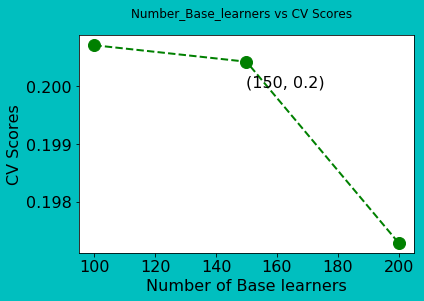

the misclassification error for each Base learners is :  [0.20071 0.20043 0.19729]


In [61]:
Optimal_Depth_Tree1=Optimal_Base_learners(final_w2v_count_Train ,Train_data)

#### Base_learners graph with different depth size

In [30]:
random_forest = RandomForestClassifier( n_jobs =-1,
                                   class_weight='balanced' ,
                                   bootstrap=True,
                                   oob_score = True)

[0.79138095 0.79152381 0.78985714 0.802      0.80385714 0.80247619
 0.79752381 0.79971429 0.7997619 ]
[8, 14, 18]
[8, 14, 18]
[8, 14, 18]


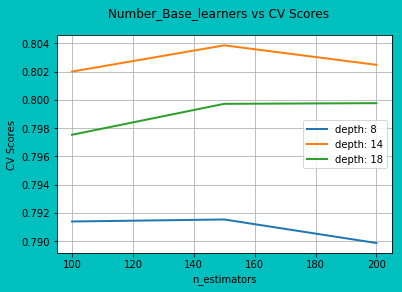

In [47]:
clf_perform_depth(random_forest,final_w2v_count_Train ,Train_data)

### Observation


* The Base learner for random Forest=150 and depth size for Tree=14.
* As seen in the results , Misclassification Error is almost similar.
* The score of model vs Base Learners with respective their depth size is as shown in graph.

## Random forest Model for optimal Parameters using Avg word2vec

In [100]:
print("Best Parameters for Random Forest is ",optimal_parameters_RF)
Best_criterion=optimal_parameters_RF.get('criterion')
Best_max_features=optimal_parameters_RF.get('max_features')
Best_n_estimators=optimal_parameters_RF.get('n_estimators')
Best_max_depth=optimal_parameters_RF.get('max_depth')

Best Parameters for Random Forest is  {'criterion': 'gini', 'max_depth': 14, 'max_features': 'sqrt', 'n_estimators': 150}


In [101]:
# Random forest classifier for optimal depth using gini index

clf1 = RandomForestClassifier(n_estimators=Best_n_estimators,
                             max_depth=Best_max_depth
                             ,criterion=Best_criterion,
                                max_features=Best_max_features,
                             random_state=0,
                             bootstrap=True,
                             oob_score = True,
                             n_jobs=-1)
clf1.fit(final_w2v_count_Train,Train_data)
RF1=clf1.fit(final_w2v_count_Train,Train_data)

In [102]:
prediction1= clf1.predict(final_w2v_count_Test)

In [103]:
#Training accuracy and training error
training_score=clf1.score(final_w2v_count_Train ,Train_data)
print('training accuracy=',training_score)
training_error=1-training_score
print('training error is =',training_error)

training accuracy= 0.9786071428571429
training error is = 0.021392857142857102


In [104]:
# Testing Accuracy and testing error for Random Forest model
Testing_score=round(accuracy_score(y_test_new ,prediction1),5)
print("Accuracy for Random Forest  model with Avg word2vec is = ",Testing_score)
Testing_error=1-Testing_score
print("Testing error for Random Forest model with Avg word2vec is = ",Testing_error)

Accuracy for Random Forest  model with Avg word2vec is =  0.80583
Testing error for Random Forest model with Avg word2vec is =  0.19416999999999995


In [105]:
F1_score = round(f1_score(y_test_new ,prediction1,average='macro'),5)*100
recall = round(recall_score(y_test_new,prediction1,average='macro'),5)*100
precision = round(precision_score(y_test_new,prediction1,average='macro'),5)*100

In [106]:
print(classification_report(y_test_new,prediction1))

             precision    recall  f1-score   support

          0       0.79      0.55      0.65      3917
          1       0.81      0.93      0.87      8083

avg / total       0.80      0.81      0.80     12000



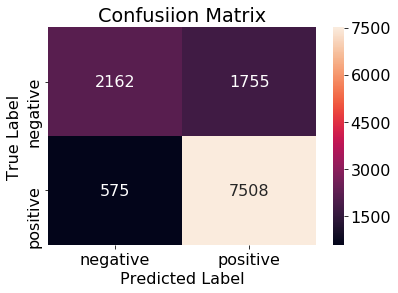

In [107]:
cm = confusion_matrix(y_test_new ,prediction1)
label = ['negative', 'positive']
df_conf = pd.DataFrame(cm, index = label, columns = label)
sns.heatmap(df_conf, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

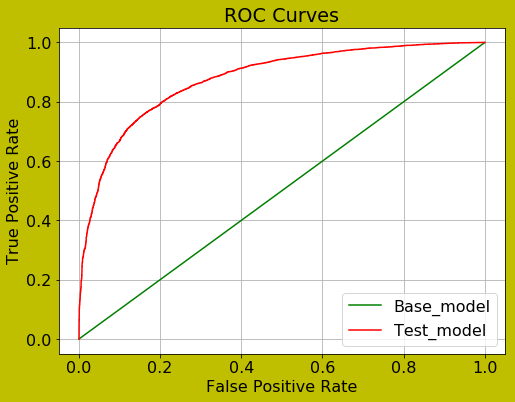

AUC: 0.878165725138325


In [108]:
roc_auc_plot(clf1,y_test_new,final_w2v_count_Test)

In [109]:

models_performence1 = {
    'Model':['Random Forest'],   
    'Vectorizer': ['Avg word2vec'],    
    'Optimal_Base_learners':[Best_n_estimators],
    'Best_criterion':[Best_criterion],
    'Best_max_features':[Best_max_features],
    'Best_max_depth':[Best_max_depth],
    'Training error':[training_error],
    'Test error':[Testing_error],
    'Accuracy':[Testing_score],
    'F1':[F1_score],
    'recall':[recall],
    'precision':[precision]
    
  
}


In [110]:
columns = ["Model","Vectorizer", "Optimal_Base_learners","Best_criterion","Best_max_features",
           "Best_max_depth","Training error",  "Test error",
            "Accuracy","F1","recall","precision",
          ]
df=pd.DataFrame(models_performence1, columns=columns)
result_display(df)

|    Model    | Vectorizer |Optimal_Base_learners|Best_criterion|Best_max_features|Best_max_depth|Training error|Test error|Accuracy| F1  |recall|precision|
|-------------|------------|--------------------:|--------------|-----------------|-------------:|-------------:|---------:|-------:|----:|-----:|--------:|
|Random Forest|Avg word2vec|                  150|gini          |sqrt             |            14|       0.02139|    0.1942|  0.8058|75.77| 74.04|    80.02|



## Observation

|    Model    | Vectorizer |Optimal_Base_learners|Best_criterion|Best_max_features|Best_max_depth|Training error|Test error|Accuracy| F1  |recall|precision|
|-------------|------------|--------------------:|--------------|-----------------|-------------:|-------------:|---------:|-------:|----:|-----:|--------:|
|Random Forest|Avg word2vec|                  150|gini          |sqrt             |            14|       0.02139|    0.1942|  0.8058|75.77| 74.04|    80.02|


* For given random Forest model , AUC is 0.878.
* The ROC curve is as shown above.
* TPR & TNR is high and FPR & FNR is low as seen in confusion matrix.
* Random Forest for Avg word2vec works very well.

## Optimal Base_learners,depth size & Learning Rate using Avg Word2Vec

Optimal_estim_GBDT=== XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=14, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

The optimal parameter for GBDT is === {'learning_rate': 0.1, 'max_depth': 14, 'n_estimators': 200}


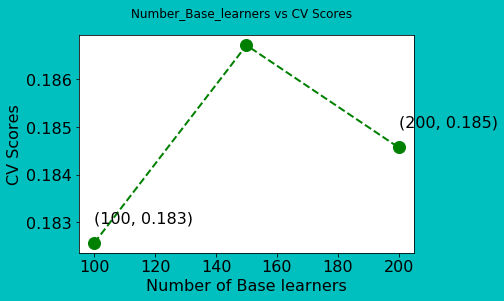

the misclassification error for each Base learners is :  [0.18257 0.18671 0.18457]


In [73]:
warnings.filterwarnings("ignore")
Optimal_BL_Depth_LR(final_w2v_count_Train,Train_data)

#### Base_learners graph with different depth size

In [31]:
GBDT_model = XGBClassifier(class_weight='balanced' )

[0.81266667 0.81471429 0.81538095 0.81166667 0.81457143 0.81552381
 0.81252381 0.81371429 0.81538095]
[8, 14, 18]
[8, 14, 18]
[8, 14, 18]


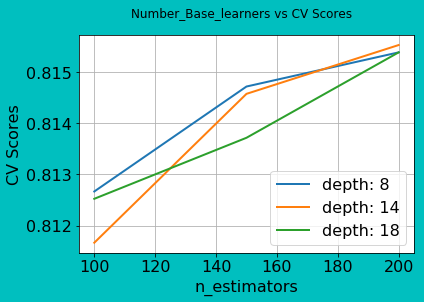

In [75]:
clf_perform_depth(GBDT_model,final_w2v_count_Train ,Train_data)

In [33]:
print("Best Parameters for GBDT is ",Optimal_param_GBDT)

Best_learning_rate=Optimal_param_GBDT.get('learning_rate')
Best_n_estimators=Optimal_param_GBDT.get('n_estimators')
Best_max_depth=Optimal_param_GBDT.get('max_depth')

Best Parameters for GBDT is  {'learning_rate': 0.1, 'max_depth': 14, 'n_estimators': 200}


3it [00:00, 151.43it/s]


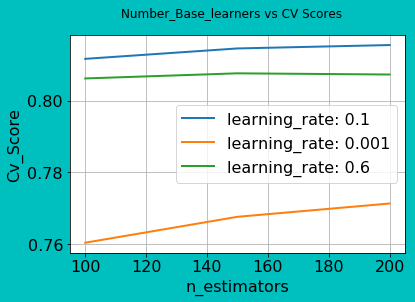

In [76]:
GBDT_LR(Best_max_depth,final_w2v_count_Train ,Train_data)

### Observation

* The optimal Base Learners is 200 ,Depth size=14 & Learning_Rate=0.1
* Misclassification error in GBDT is almost similar as seen in graph .
* The graphs for  Number of base learners Vs Score with different depth size and learning rate is seen

### GBDT Model for optimal Parameters using Avg word2vec

In [34]:
# GBDT classifier for optimal depth using gini index
GBDT_clf1 = XGBClassifier(n_estimators=Best_n_estimators,
                          learning_rate=Best_learning_rate,
                            max_depth=Best_max_depth,
                          scoring="sqrt",
                          n_jobs=-1, verbose=1)
GBDT_clf1.fit(final_w2v_count_Train,Train_data)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=14, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       scoring='sqrt', seed=None, silent=True, subsample=1, verbose=1)

In [35]:
prediction11= GBDT_clf1.predict(final_w2v_count_Test)
#print(prediction11)

/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [36]:
#Training accuracy and training error
training_score=GBDT_clf1.score(final_w2v_count_Train ,Train_data)
print('training accuracy=',training_score)
training_error=1-training_score
print('training error is =',training_error)

training accuracy= 0.9995
training error is = 0.0004999999999999449


/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [37]:
# Testing Accuracy and testing error for GBDT model
Testing_score=round(accuracy_score(y_test_new ,prediction11),5)
print("Accuracy for GBDT  model with Avg word2vec is = ",Testing_score)
Testing_error=1-Testing_score
print("Testing error for GBDT model with Avg word2vec is = ",Testing_error)

Accuracy for GBDT  model with Avg word2vec is =  0.66767
Testing error for GBDT model with Avg word2vec is =  0.33233


In [38]:
F1_score = round(f1_score(y_test_new ,prediction11,average='macro'),5)*100
recall = round(recall_score(y_test_new,prediction11,average='macro'),5)*100
precision = round(precision_score(y_test_new ,prediction11,average='macro'),5)*100

In [39]:
print(classification_report( y_test_new,prediction11))

             precision    recall  f1-score   support

          0       0.34      0.02      0.03      3932
          1       0.67      0.99      0.80      8068

avg / total       0.56      0.67      0.55     12000



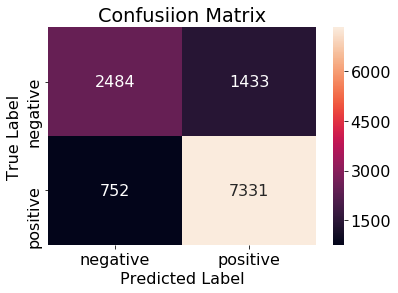

In [121]:
cm = confusion_matrix(y_test_new ,prediction11)
label = ['negative', 'positive']
df_conf = pd.DataFrame(cm, index = label, columns = label)
sns.heatmap(df_conf, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### ROC_AUC_plot

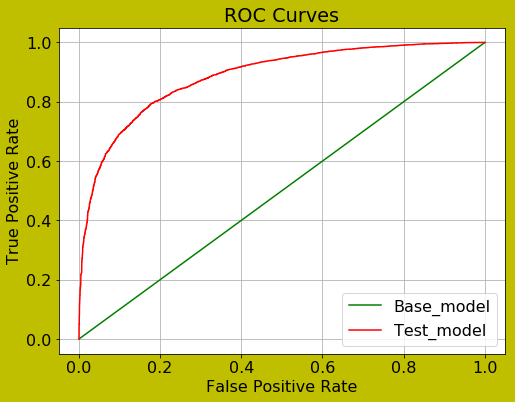

AUC: 0.8863660848793337


In [122]:
roc_auc_plot(GBDT_clf1,y_test_new,final_w2v_count_Test)

In [123]:

models_performence = {
    'Model':['GBDT'],   
    'Vectorizer': ['Avg word2vec'],    
    'Optimal_Base_learners':[Best_n_estimators],
    'Best_learning_rate':[Best_learning_rate],
    'Best_max_depth':[Best_max_depth],
    'Training error':[training_error],
    'Test error':[Testing_error],
    'Accuracy':[Testing_score],
    'F1':[F1_score],
    'recall':[recall],
    'precision':[precision]
    
  
}


In [124]:
columns = ["Model","Vectorizer", "Optimal_Base_learners","Best_learning_rate","Best_max_depth",
          "Training error",  "Test error",
            "Accuracy","F1","recall","precision",
          ]
df1=pd.DataFrame(models_performence, columns=columns)
result_display(df1)

|Model| Vectorizer |Optimal_Base_learners|Best_learning_rate|Best_max_depth|Training error|Test error|Accuracy| F1  |recall|precision|
|-----|------------|--------------------:|-----------------:|-------------:|-------------:|---------:|-------:|----:|-----:|--------:|
|GBDT |Avg word2vec|                  200|               0.1|            14|      0.000071|    0.1821|  0.8179|78.24| 77.06|    80.20|



## Observation:




|Model| Vectorizer |Optimal_Base_learners|Best_learning_rate|Best_max_depth|Training error|Test error|Accuracy| F1  |recall|precision|
|-----|------------|--------------------:|-----------------:|-------------:|-------------:|---------:|-------:|----:|-----:|--------:|
|GBDT |Avg word2vec|                  200|               0.1|            14|      0.000071|    0.1821|  0.8179|78.24| 77.06|    80.20|

* For given GBDT model AUC is 0.88
* Model performs well as TPR is too high and TNR is quite high and FPR &FNR is low  as observered in Confusion Matrix.


#  2.TF-IDF weighted Word2Vec

In [40]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=100)

In [41]:

tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf11 = tf_idf_vect.fit_transform(X_train_data.values.ravel())
final_tf_idf11.get_shape()


(28000, 496181)

In [127]:
final_tf_idf=svd.fit_transform(final_tf_idf11 )
print("TruncatedSVD :",final_tf_idf.shape)

TruncatedSVD : (28000, 100)


In [59]:
tfidf_feat = tf_idf_vect.get_feature_names() 
w2v_words = list(w2v_model.wv.vocab)
dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))

In [129]:
list_of_sent=[]
for sent in tqdm(X_train_data.values.ravel()):
    list_of_sent.append(sent.decode("utf-8").split())

100%|██████████| 28000/28000 [00:00<00:00, 197925.22it/s]


In [130]:
# TF-IDF weighted Word2Vec
tfidf_feat =tf_idf_vect.get_feature_names() # tfidf words/col-names

tfidf_sent_vectors = []; 
row=0;
for sent in tqdm(list_of_sent): 
    sent_vec = np.zeros(100) 
    weight_sum =0;
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors .append(sent_vec)
    row += 1

100%|██████████| 28000/28000 [00:55<00:00, 503.67it/s]


In [131]:
print(len(tfidf_sent_vectors))

28000


In [132]:

tfidf_sent_vectors_train  = np.where(np.isnan(tfidf_sent_vectors ), 0, tfidf_sent_vectors )


In [133]:
tfidf_sent_vectors_train  = np.asarray(tfidf_sent_vectors_train )
print(type(tfidf_sent_vectors))

<class 'list'>


#### Dumping & Loading Pickle file for trainText data (TF-IDF weighted word2vec)

In [134]:
pickle_path_tfidf_weighted='X_data_tfidf_weighted.pkl'
X_data_tfidf_weighted=open(pickle_path_tfidf_weighted,'wb')
pickle.dump(tfidf_sent_vectors_train  ,X_data_tfidf_weighted)
X_data_tfidf_weighted.close()

In [135]:
pickle_path_tfidf_weighted='X_data_tfidf_weighted.pkl'
unpickle_path7=open(pickle_path_tfidf_weighted,'rb')
tfidf_sent_vectors_train =pickle.load(unpickle_path7)

In [136]:

final_tfidf_w2v_np_train=tfidf_sent_vectors_train
print(final_tfidf_w2v_np_train.shape)

(28000, 100)


##### For test Tf-idf weighted word2vec

In [137]:
list_of_sent1=[]
for sent in tqdm(X_test_data.values.ravel()):
    list_of_sent1.append(sent.decode("utf-8").split())

100%|██████████| 12000/12000 [00:00<00:00, 131725.14it/s]


In [138]:
# TF-IDF weighted Word2Vec
tfidf_feat =tf_idf_vect.get_feature_names() # tfidf words/col-names

tfidf_sent_vectors1 = []; 
row=0;
for sent in tqdm(list_of_sent1): 
    sent_vec = np.zeros(100) 
    weight_sum =0;
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors1 .append(sent_vec)
    row += 1

100%|██████████| 12000/12000 [00:26<00:00, 461.14it/s]


In [139]:

tfidf_sent_vectors_test  = np.where(np.isnan(tfidf_sent_vectors1 ),
                                     0, tfidf_sent_vectors1 )

final_tfidf_w2v_np_test = np.asarray(tfidf_sent_vectors_test )


#### Dumping & Loading Pickle file for test Text data (TF-IDF weighted word2vec)

In [140]:
pickle_path_tfidf_weighted1='X_data_tfidf_weighted_test.pkl'
X_data_tfidf_weighted1=open(pickle_path_tfidf_weighted1,'wb')
pickle.dump(final_tfidf_w2v_np_test  ,X_data_tfidf_weighted1)
X_data_tfidf_weighted1.close()

In [141]:
pickle_path_tfidf_weighted1='X_data_tfidf_weighted_test.pkl'
unpickle_path71=open(pickle_path_tfidf_weighted1,'rb')
final_tfidf_w2v_np_test1 =pickle.load(unpickle_path71)

In [142]:
final_tfidf_w2v_np_test=final_tfidf_w2v_np_test1

In [143]:
joblib.dump(final_tfidf_w2v_np_train, 'tfidf_weighted_train.joblib')
joblib.dump(final_tfidf_w2v_np_test, 'tfidf_weighted_test.joblib')

['tfidf_weighted_test.joblib']

In [42]:
final_tfidf_w2v_np_train = joblib.load('tfidf_weighted_train.joblib')
final_tfidf_w2v_np_test = joblib.load('tfidf_weighted_test.joblib')

for Training Data:

            
            final_tfidf_w2v_np_train

For testing data:

            
            final_tfidf_w2v_np_test
    

## Optimal Base_learners for Random Forest using TF-IDF weighted Word2Vec

optimal_estim== RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=14, max_features='log2',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=-1, oob_score=True, random_state=None,
            verbose=0, warm_start=False)
Mean of score: 0.7866190476190477
Variance of scores: 1.0698412698412597e-05

The optimal Best_parameters for Random Forest is ===  {'criterion': 'gini', 'max_depth': 14, 'max_features': 'log2', 'n_estimators': 200}


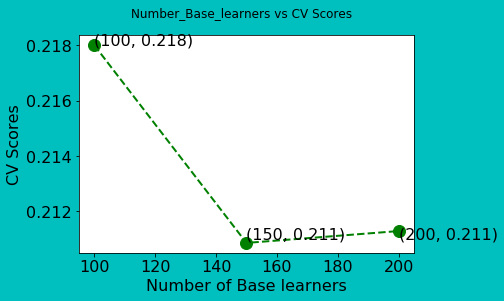

the misclassification error for each Base learners is :  [0.218   0.21086 0.21129]


In [110]:
Optimal_Depth_Tree1=Optimal_Base_learners(final_tfidf_w2v_np_train ,Train_data)

#### Base_learners graph with different depth size

In [43]:
random_forest = RandomForestClassifier( n_jobs =-1,
                                   class_weight='balanced' ,
                                   bootstrap=True,
                                   oob_score = True)

[0.58238095 0.58609524 0.58657143 0.67119048 0.68057143 0.68114286
 0.69785714 0.70057143 0.701     ]
[8, 14, 18]
[8, 14, 18]
[8, 14, 18]


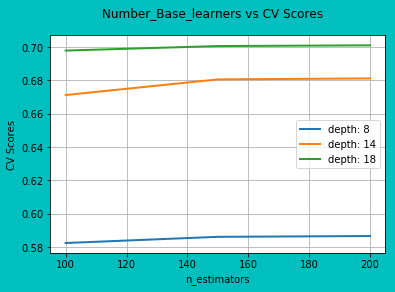

In [46]:

clf_perform_depth(random_forest,final_tfidf_w2v_np_train ,Train_data)

## Random Forest for optimal Parametersusing TF-IDF weighted Word2Vec

In [146]:
optimal_parameters_RF={'criterion': 'gini', 'max_depth': 14, 'max_features': 'log2', 'n_estimators': 200}

In [147]:
#print("Best Parameters for Random Forest is ",optimal_parameters_RF)
Best_criterion=optimal_parameters_RF.get('criterion')
Best_max_features=optimal_parameters_RF.get('max_features')
Best_n_estimators=optimal_parameters_RF.get('n_estimators')
Best_max_depth=optimal_parameters_RF.get('max_depth')

In [148]:

RF_clf2 = RandomForestClassifier(n_estimators=Best_n_estimators,max_depth=Best_max_depth,criterion=Best_criterion,
                                max_features=Best_max_features, random_state=0,n_jobs=-1)
RF_clf2.fit(final_tfidf_w2v_np_train,Train_data)
RF2=RF_clf2.fit(final_tfidf_w2v_np_train,Train_data)


In [149]:
prediction2= RF_clf2.predict(final_tfidf_w2v_np_test)

In [150]:
#Training accuracy and training error
training_score=RF_clf2.score(final_tfidf_w2v_np_train,Train_data)
print('training accuracy=',training_score)
training_error=1-training_score
print('training error is =',training_error)

training accuracy= 0.9718214285714286
training error is = 0.028178571428571386


In [151]:
# Testing Accuracy and testing error for Random Forest model
Testing_score=round(accuracy_score(y_test_new ,prediction2),5)
print("Accuracy for Random Forest model with TF-IDF weighted Word2Vec is = ",Testing_score)
Testing_error=1-Testing_score
print("Testing error for Random Forest model with TF-IDF weighted Word2Vec is = ",Testing_error)

Accuracy for Random Forest model with TF-IDF weighted Word2Vec is =  0.77783
Testing error for Random Forest model with TF-IDF weighted Word2Vec is =  0.22216999999999998


In [152]:
F1_score = round(f1_score(y_test_new ,prediction2,average='macro'),5)*100
recall = round(recall_score(y_test_new,prediction2,average='macro'),5)*100
precision = round(precision_score(y_test_new ,prediction2,average='macro'),5)*100

In [153]:
print(classification_report( y_test_new,prediction2))

             precision    recall  f1-score   support

          0       0.77      0.45      0.57      3917
          1       0.78      0.94      0.85      8083

avg / total       0.78      0.78      0.76     12000



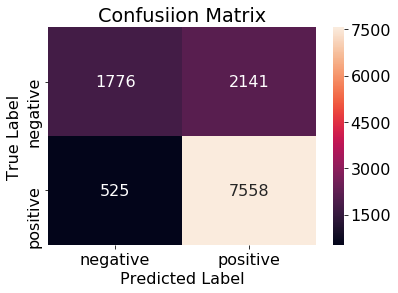

In [154]:
cm = confusion_matrix(y_test_new,prediction2)
label = ['negative', 'positive']
df_conf = pd.DataFrame(cm, index = label, columns = label)
sns.heatmap(df_conf, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### ROC_AUC_plot

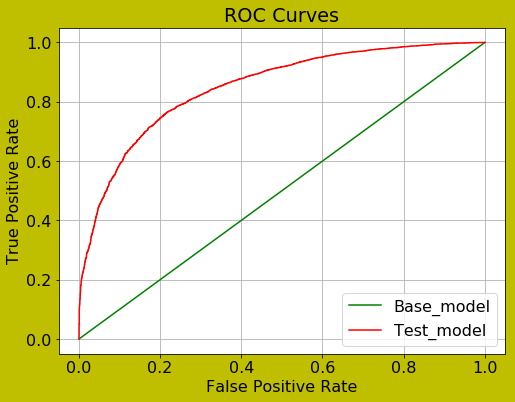

AUC: 0.8494367585521556


In [155]:
roc_auc_plot(RF_clf2,y_test_new,final_tfidf_w2v_np_test)

In [156]:
models_performence1['Model'].append('Random Forest')
models_performence1['Vectorizer'].append('TF-IDF weighted word2vec')
models_performence1['Optimal_Base_learners'].append(Best_n_estimators)
models_performence1['Best_criterion'].append(Best_criterion)
models_performence1['Best_max_features'].append(Best_max_features)
models_performence1['Best_max_depth'].append(Best_max_depth)
models_performence1['Training error'].append(training_error)
models_performence1[ 'Test error'].append(Testing_error)
models_performence1[ 'Accuracy'].append(Testing_score)
models_performence1[ 'F1'].append(F1_score)
models_performence1['recall'].append(recall)
models_performence1[ 'precision'].append(precision)

In [157]:
columns = ["Model","Vectorizer", "Optimal_Base_learners","Best_criterion","Best_max_features",
           "Best_max_depth","Training error",  "Test error",
            "Accuracy","F1","recall","precision",
          ]
df2=pd.DataFrame(models_performence1, columns=columns)
result_display(df2)

|    Model    |       Vectorizer       |Optimal_Base_learners|Best_criterion|Best_max_features|Best_max_depth|Training error|Test error|Accuracy| F1  |recall|precision|
|-------------|------------------------|--------------------:|--------------|-----------------|-------------:|-------------:|---------:|-------:|----:|-----:|--------:|
|Random Forest|Avg word2vec            |                  150|gini          |sqrt             |            14|       0.02139|    0.1942|  0.8058|75.77| 74.04|    80.02|
|Random Forest|TF-IDF weighted word2vec|                  200|gini          |log2             |            14|       0.02818|    0.2222|  0.7778|71.07| 69.42|    77.55|



## Observation:


|    Model    |       Vectorizer       |Optimal_Base_learners|Best_criterion|Best_max_features|Best_max_depth|Training error|Test error|Accuracy| F1  |recall|precision|
|-------------|------------------------|--------------------:|--------------|-----------------|-------------:|-------------:|---------:|-------:|----:|-----:|--------:|
|Random Forest|Avg word2vec            |                  150|gini          |sqrt             |            14|       0.02139|    0.1942|  0.8058|75.77| 74.04|    80.02|
|Random Forest|TF-IDF weighted word2vec|                  200|gini          |log2             |            14|       0.02818|    0.2222|  0.7778|71.07| 69.42|    77.55|

* For given Random Forest , AUC is 0.849 .
* TPR is high and FPR & TNR is almost similar.But ROC graph & AUC is quite good.

## Optimal Base_learners,depth size & Learning Rate using TF-IDF Avg Word2Vec

Optimal_estim_GBDT=== XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=8, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

The optimal parameter for GBDT is === {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200}


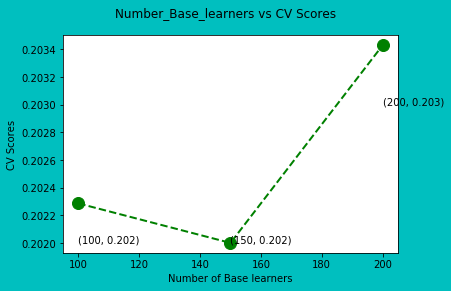

the misclassification error for each Base learners is :  [0.20229 0.202   0.20343]


In [82]:
warnings.filterwarnings("ignore")
Optimal_BL_Depth_LR(final_tfidf_w2v_np_train,Train_data)

#### Base_learners graph with different depth size

[0.79733333 0.79890476 0.79928571 0.79590476 0.79690476 0.79771429
 0.79395238 0.79438095 0.79585714]
[8, 14, 18]
[8, 14, 18]
[8, 14, 18]


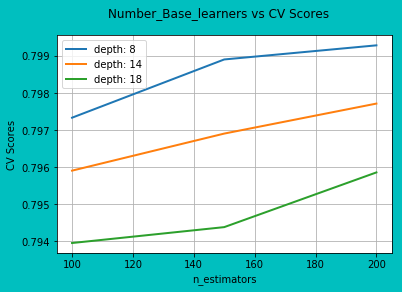

In [83]:

clf_perform_depth(GBDT_model,final_tfidf_w2v_np_train ,Train_data)

## GBDT Model for optimal Parameters

In [45]:
print("Best Parameters for GBDT is ",Optimal_param_GBDT)

Best_learning_rate=Optimal_param_GBDT.get('learning_rate')
Best_n_estimators=Optimal_param_GBDT.get('n_estimators')
Best_max_depth=Optimal_param_GBDT.get('max_depth')

Best Parameters for GBDT is  {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200}


3it [00:00, 149.60it/s]


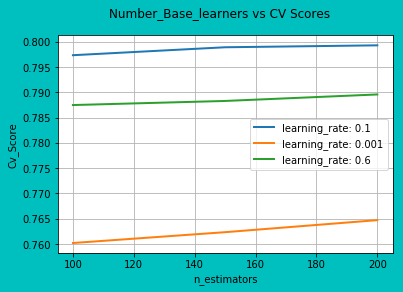

In [85]:
GBDT_LR(Best_max_depth,final_tfidf_w2v_np_train ,Train_data)

In [46]:
# GBDT classifier for optimal parametrs

GBDT_clf12 = XGBClassifier(n_estimators=Best_n_estimators,
                           learning_rate=Best_learning_rate,
                                max_depth=Best_max_depth,
                           scoring="sqrt",
                          n_jobs=-1, cv=tscv, verbose=1)
GBDT_clf12.fit(final_tfidf_w2v_np_train, Train_data)



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1,
       cv=TimeSeriesSplit(max_train_size=None, n_splits=3), gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=None, n_estimators=200, n_jobs=-1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, scoring='sqrt',
       seed=None, silent=True, subsample=1, verbose=1)

In [161]:
prediction12= GBDT_clf12.predict(final_tfidf_w2v_np_test)

/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [162]:
#Training accuracy and training error
training_score=GBDT_clf12.score(final_tfidf_w2v_np_train,Train_data)
print('training accuracy=',training_score)
training_error=1-training_score
print('training error is =',training_error)

training accuracy= 0.99475
training error is = 0.005249999999999977


/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [163]:
# Testing Accuracy and testing error for GBDT model
Testing_score=round(accuracy_score(y_test_new,prediction12),5)
print("Accuracy for GBDT model with Avg word2vec is = ",Testing_score)
Testing_error=1-Testing_score
print("Testing error for GBDT model with Avg word2vec is = ",Testing_error)

Accuracy for GBDT model with Avg word2vec is =  0.79575
Testing error for GBDT model with Avg word2vec is =  0.20425000000000004


In [164]:
F1_score = round(f1_score(y_test_new,prediction12,average='macro'),5)*100
recall = round(recall_score(y_test_new,prediction12,average='macro'),5)*100
precision = round(precision_score(y_test_new ,prediction12,average='macro'),5)*100

In [165]:
print(classification_report( y_test_new,prediction12))

             precision    recall  f1-score   support

          0       0.74      0.58      0.65      3917
          1       0.82      0.90      0.86      8083

avg / total       0.79      0.80      0.79     12000



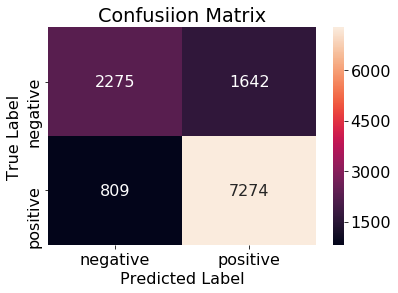

In [166]:
cm = confusion_matrix(y_test_new,prediction12)
label = ['negative', 'positive']
df_conf = pd.DataFrame(cm, index = label, columns = label)
sns.heatmap(df_conf, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

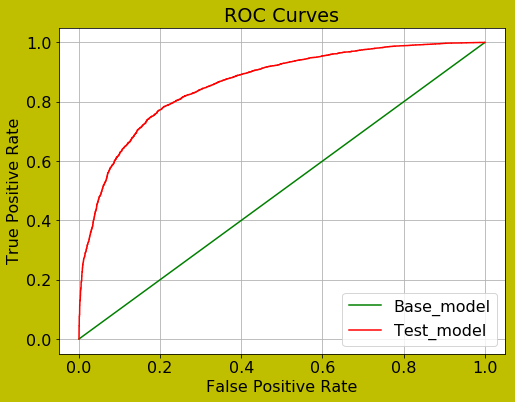

AUC: 0.8622118945857585


In [167]:
roc_auc_plot(GBDT_clf12,y_test_new,final_tfidf_w2v_np_test)

In [168]:
models_performence['Model'].append('GBDT')
models_performence['Vectorizer'].append('TF-IDF weighted word2vec')
models_performence['Optimal_Base_learners'].append(Best_n_estimators)
models_performence['Best_learning_rate'].append(Best_learning_rate)
models_performence['Best_max_depth'].append(Best_max_depth)
models_performence['Training error'].append(training_error)
models_performence[ 'Test error'].append(Testing_error)
models_performence[ 'Accuracy'].append(Testing_score)
models_performence[ 'F1'].append(F1_score)
models_performence['recall'].append(recall)
models_performence[ 'precision'].append(precision)

In [169]:
columns = ["Model","Vectorizer", "Optimal_Base_learners","Best_learning_rate","Best_max_depth",
          "Training error",  "Test error",
            "Accuracy","F1","recall","precision",
          ]
df4=pd.DataFrame(models_performence, columns=columns)

## Observation

|Model|       Vectorizer       |Optimal_Base_learners|Best_learning_rate|Best_max_depth|Training error|Test error|Accuracy| F1  |recall|precision|
|-----|------------------------|--------------------:|-----------------:|-------------:|-------------:|---------:|-------:|----:|-----:|--------:|
|GBDT |Avg word2vec            |                  200|               0.1|            14|      0.000071|    0.1821|  0.8179|78.24| 77.06|    80.20|
|GBDT |TF-IDF weighted word2vec|                  200|               0.1|             8|      0.005250|    0.2043|  0.7957|75.29| 74.04|    77.68|


 * ROC & AUC=0.862 for given GBDT model which is good comparatively GBDTusing Avg Word2vec model.
 * TPR & TNR is high and FPR & FNR is low. It means model performs well.

# 3. Bag of Words (BoW)

##### BOW for Training Data

In [47]:
count_vect = CountVectorizer() #in scikit-learn
vect_Data = count_vect.fit_transform(X_train_data.values.ravel())
print(vect_Data .shape)

(28000, 20694)


In [171]:
# truncated SVD for dimesionality reduction for 100 dimensions
svd = TruncatedSVD(n_components=100)

final_data=svd.fit_transform(vect_Data )
print("TruncatedSVD :",final_data.shape)
    

TruncatedSVD : (28000, 100)


#### Dumping & Loading Pickle file for training data ( BOW )


In [172]:
#Pickle file for training data
import pickle
pickle_path_BOW_train='X_train_data_BOW.pkl'
X_train_data_BOW=open(pickle_path_BOW_train,'wb')
pickle.dump(final_data ,X_train_data_BOW)
X_train_data_BOW.close()


In [173]:
pickle_path_BOW_train='X_train_data_BOW.pkl'
unpickle_path1=open(pickle_path_BOW_train,'rb')
final_data=pickle.load(unpickle_path1)

##### BOW for Testing Data

In [174]:
#vector of test data
vect_Data1= count_vect.transform(X_test_data.values.ravel())
print(vect_Data1.shape)


final_data_test=svd.transform(vect_Data1)
print("TruncatedSVD :",final_data_test.shape)

(12000, 20835)
TruncatedSVD : (12000, 100)


#### Dumping & Loading Pickle file for testing data ( BOW) 

In [175]:
pickle_path_BOW_test='X_test_data_BOW.pkl'
X_test_data_BOW=open(pickle_path_BOW_test,'wb')
pickle.dump(final_data_test ,X_test_data_BOW)
X_test_data_BOW.close()

In [176]:
pickle_path_BOW_test='X_test_data_BOW.pkl'
unpickle_path2=open(pickle_path_BOW_test,'rb')
final_data_test=pickle.load(unpickle_path2)

In [177]:
joblib.dump(final_data, 'BOW_train.joblib')


['BOW_train.joblib']

In [178]:
joblib.dump(final_data_test, 'BOW_test.joblib')

['BOW_test.joblib']

In [48]:
final_data = joblib.load('BOW_train.joblib')
final_data_test = joblib.load('BOW_test.joblib')

## Optimal Base_learners for Random Forest using BOW

In [48]:
print(Train_data.shape)

(28000,)


optimal_estim== RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=8, max_features='log2',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=150, n_jobs=-1, oob_score=True, random_state=None,
            verbose=0, warm_start=False)
Mean of score: 0.7527619047619046
Variance of scores: 1.1678004535147496e-05

The optimal Best_parameters for Random Forest is ===  {'criterion': 'gini', 'max_depth': 8, 'max_features': 'log2', 'n_estimators': 150}


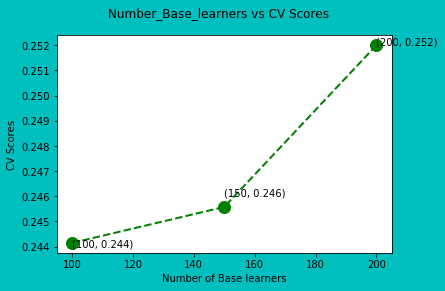

the misclassification error for each Base learners is :  [0.24414 0.24557 0.252  ]


In [78]:
Optimal_Depth_Tree1=Optimal_Base_learners(final_data ,Train_data)

#### Base_learners graph with different depth size

[0.74457143 0.74595238 0.74733333 0.75085714 0.752      0.75119048
 0.74080952 0.73947619 0.74119048]
[8, 14, 18]
[8, 14, 18]
[8, 14, 18]


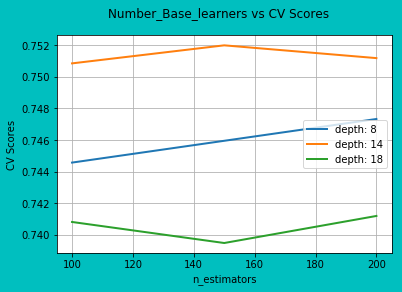

In [79]:
clf_perform_depth(random_forest,final_data ,Train_data)

## Random Forest for optimal Parameters using BOW

In [182]:
print("Best Parameters for Random Forest is ",optimal_parameters_RF)
Best_criterion=optimal_parameters_RF.get('criterion')
Best_max_features=optimal_parameters_RF.get('max_features')
Best_n_estimators=optimal_parameters_RF.get('n_estimators')
Best_max_depth=optimal_parameters_RF.get('max_depth')

Best Parameters for Random Forest is  {'criterion': 'gini', 'max_depth': 8, 'max_features': 'log2', 'n_estimators': 150}


In [183]:

RF_clf3 = RandomForestClassifier(n_estimators=Best_n_estimators,max_depth=Best_max_depth,criterion=Best_criterion,
                                max_features=Best_max_features, random_state=0,n_jobs=-1)
RF_clf3.fit(final_data,Train_data)
RF3=RF_clf3.fit(final_data,Train_data)


In [184]:
prediction3= RF_clf3.predict(final_data_test)

In [185]:
#Training accuracy and training error
training_score=RF_clf3.score(final_data,Train_data)
print('training accuracy=',training_score)
training_error=1-training_score
print('training error is =',training_error)

training accuracy= 0.73775
training error is = 0.26225


In [186]:
# Testing Accuracy and testing error for Random Forest model

Testing_score=round(accuracy_score(y_test_new,prediction3),5)
print("Accuracy for Random Forest model with BOW is = ",Testing_score)
Testing_error=1-Testing_score
print("Testing error for Random Forest model with BOW is = ",Testing_error)

Accuracy for Random Forest model with BOW is =  0.68217
Testing error for Random Forest model with BOW is =  0.31782999999999995


In [187]:
F1_score = round(f1_score(y_test_new,prediction3,average='macro'),5)*100
recall = round(recall_score(y_test_new,prediction3,average='macro'),5)*100
precision = round(precision_score(y_test_new ,prediction3,average='macro'),5)*100

In [188]:
print(classification_report( y_test_new,prediction3))

             precision    recall  f1-score   support

          0       0.87      0.03      0.06      3917
          1       0.68      1.00      0.81      8083

avg / total       0.74      0.68      0.56     12000



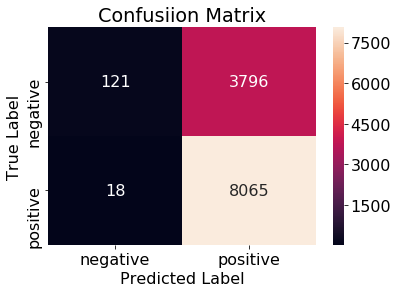

In [189]:
cm = confusion_matrix(y_test_new ,prediction3)
label = ['negative', 'positive']
df_conf = pd.DataFrame(cm, index = label, columns = label)
sns.heatmap(df_conf, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### ROC_AUC_plot

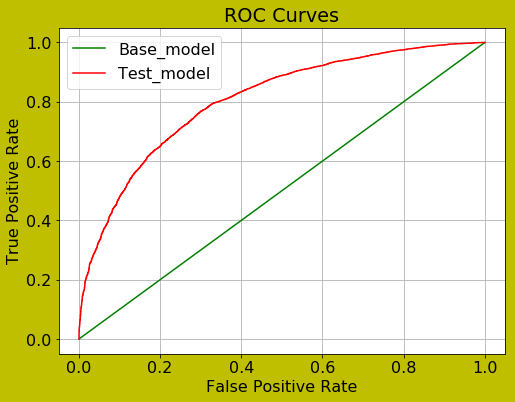

AUC: 0.8057046229363208


In [190]:
roc_auc_plot(RF_clf3,y_test_new,final_data_test)

In [191]:
models_performence1['Model'].append('Random Forest')
models_performence1['Vectorizer'].append('BOW')
models_performence1['Optimal_Base_learners'].append(Best_n_estimators)
models_performence1['Best_criterion'].append(Best_criterion)
models_performence1['Best_max_features'].append(Best_max_features)
models_performence1['Best_max_depth'].append(Best_max_depth)
models_performence1['Training error'].append(training_error)
models_performence1[ 'Test error'].append(Testing_error)
models_performence1[ 'Accuracy'].append(Testing_score)
models_performence1[ 'F1'].append(F1_score)
models_performence1['recall'].append(recall)
models_performence1[ 'precision'].append(precision)

In [192]:
columns = ["Model","Vectorizer", "Optimal_Base_learners","Best_criterion","Best_max_features",
           "Best_max_depth","Training error",  "Test error",
            "Accuracy","F1","recall","precision",
          ]
df5=pd.DataFrame(models_performence1, columns=columns)
result_display(df5)

|    Model    |       Vectorizer       |Optimal_Base_learners|Best_criterion|Best_max_features|Best_max_depth|Training error|Test error|Accuracy| F1  |recall|precision|
|-------------|------------------------|--------------------:|--------------|-----------------|-------------:|-------------:|---------:|-------:|----:|-----:|--------:|
|Random Forest|Avg word2vec            |                  150|gini          |sqrt             |            14|       0.02139|    0.1942|  0.8058|75.77| 74.04|    80.02|
|Random Forest|TF-IDF weighted word2vec|                  200|gini          |log2             |            14|       0.02818|    0.2222|  0.7778|71.07| 69.42|    77.55|
|Random Forest|BOW                     |                  150|gini          |log2             |             8|       0.26225|    0.3178|  0.6822|43.42| 51.43|    77.52|



## Observation 

|    Model    |       Vectorizer       |Optimal_Base_learners|Best_criterion|Best_max_features|Best_max_depth|Training error|Test error|Accuracy| F1  |recall|precision|
|-------------|------------------------|--------------------:|--------------|-----------------|-------------:|-------------:|---------:|-------:|----:|-----:|--------:|
|Random Forest|Avg word2vec            |                  150|gini          |sqrt             |            14|       0.02139|    0.1942|  0.8058|75.77| 74.04|    80.02|
|Random Forest|TF-IDF weighted word2vec|                  200|gini          |log2             |            14|       0.02818|    0.2222|  0.7778|71.07| 69.42|    77.55|
|Random Forest|BOW                     |                  150|gini          |log2             |             8|       0.26225|    0.3178|  0.6822|43.42| 51.43|    77.52|

* The results for BOW is quite low as comapred Avgword2vec & TF-IDf weighted word2vec.
* From confusion matrix, It is observed that TPR & FPR is too high as compared to TNR &FNR.


## Optimal Base_learners,depth size & Learning Rate using BOW

Optimal_estim_GBDT=== XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=8, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

The optimal parameter for GBDT is === {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200}


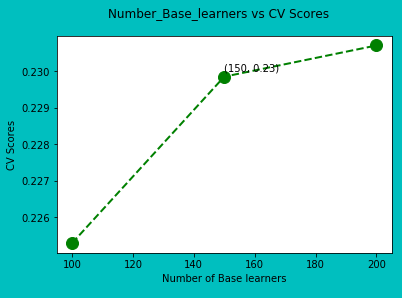

the misclassification error for each Base learners is :  [0.22529 0.22986 0.23071]


In [80]:
warnings.filterwarnings("ignore")
Optimal_BL_Depth_LR(final_data,Train_data)

#### Base_learners graph with different depth size

[0.76990476 0.77147619 0.77219048 0.76819048 0.77071429 0.771
 0.76752381 0.77042857 0.77219048]
[8, 14, 18]
[8, 14, 18]
[8, 14, 18]


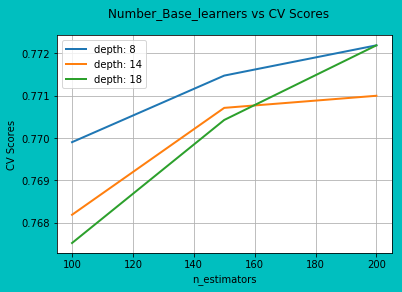

In [81]:

clf_perform_depth(GBDT_model,final_data,Train_data)

## GBDT Model for optimal Parameters

In [50]:
print("Best Parameters for GBDT is ",Optimal_param_GBDT)

Best_learning_rate=Optimal_param_GBDT.get('learning_rate')
Best_n_estimators=Optimal_param_GBDT.get('n_estimators')
Best_max_depth=Optimal_param_GBDT.get('max_depth')

Best Parameters for GBDT is  {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200}


3it [00:00, 152.02it/s]


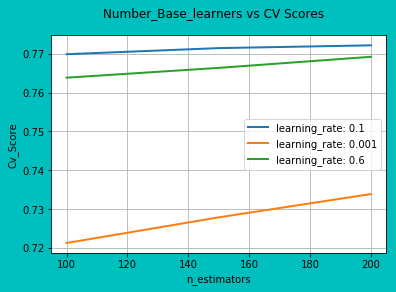

In [83]:
GBDT_LR(Best_max_depth,final_data ,Train_data)

In [51]:
# GBDT classifier for optimal parametrs
GBDT_clf13 = XGBClassifier(n_estimators=Best_n_estimators,
                           learning_rate=Best_learning_rate,
                            max_depth=Best_max_depth,
                           scoring="sqrt",
                          n_jobs=-1, cv=tscv, verbose=1)
GBDT_clf13.fit(final_data, Train_data)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1,
       cv=TimeSeriesSplit(max_train_size=None, n_splits=3), gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=None, n_estimators=200, n_jobs=-1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, scoring='sqrt',
       seed=None, silent=True, subsample=1, verbose=1)

In [196]:
prediction13= GBDT_clf13.predict(final_data_test)

/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [197]:
#Training accuracy and training error
training_score=GBDT_clf13.score(final_data,Train_data)
print('training accuracy=',training_score)
training_error=1-training_score
print('training error is =',training_error)

training accuracy= 0.998
training error is = 0.0020000000000000018


/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [198]:
# Testing Accuracy and testing error for GBDT model
Testing_score=round(accuracy_score(y_test_new ,prediction13),5)
print("Accuracy for GBDT model with BOW is = ",Testing_score)
Testing_error=1-Testing_score
print("Testing error for GBDT model with BOW is = ",Testing_error)

Accuracy for GBDT model with BOW is =  0.77383
Testing error for GBDT model with BOW is =  0.22616999999999998


In [199]:
# Testing Accuracy and testing error for GBDT model
Testing_score=round(accuracy_score(y_test_new,prediction13),5)
print("Accuracy for GBDT model with BOW is = ",Testing_score)
Testing_error=1-Testing_score
print("Testing error for GBDT model with BOW is = ",Testing_error)

Accuracy for GBDT model with BOW is =  0.77383
Testing error for GBDT model with BOW is =  0.22616999999999998


In [200]:
F1_score = round(f1_score(y_test_new,prediction13,average='macro'),5)*100
recall = round(recall_score(y_test_new,prediction13,average='macro'),5)*100
precision = round(precision_score(y_test_new,prediction13,average='macro'),5)*100

In [201]:
print(classification_report( y_test_new,prediction13))

             precision    recall  f1-score   support

          0       0.72      0.50      0.59      3917
          1       0.79      0.91      0.84      8083

avg / total       0.77      0.77      0.76     12000



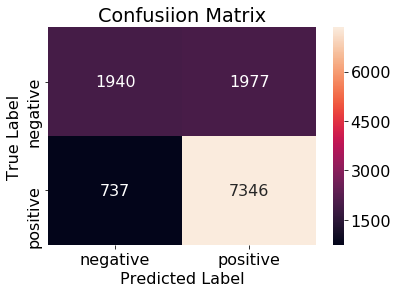

In [202]:
cm = confusion_matrix(y_test_new,prediction13)
label = ['negative', 'positive']
df_conf = pd.DataFrame(cm, index = label, columns = label)
sns.heatmap(df_conf, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### ROC_AUC_plot

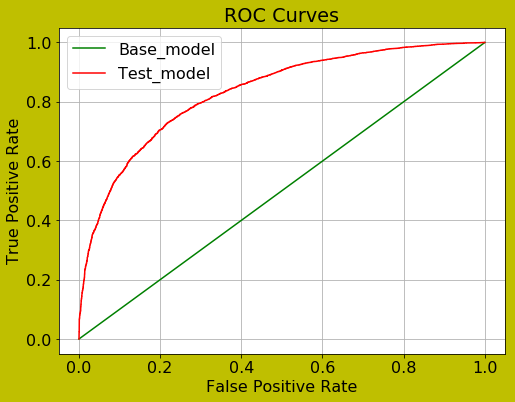

AUC: 0.8321837948137701


In [203]:
roc_auc_plot(GBDT_clf13,y_test_new,final_data_test)

In [204]:
models_performence['Model'].append('GBDT')
models_performence['Vectorizer'].append('BOW')
models_performence['Optimal_Base_learners'].append(Best_n_estimators)
models_performence['Best_learning_rate'].append(Best_learning_rate)
models_performence['Best_max_depth'].append(Best_max_depth)
models_performence['Training error'].append(training_error)
models_performence[ 'Test error'].append(Testing_error)
models_performence[ 'Accuracy'].append(Testing_score)
models_performence[ 'F1'].append(F1_score)
models_performence['recall'].append(recall)
models_performence[ 'precision'].append(precision)

In [205]:
columns = ["Model","Vectorizer", "Optimal_Base_learners","Best_learning_rate","Best_max_depth",
          "Training error",  "Test error",
            "Accuracy","F1","recall","precision",
          ]
df6=pd.DataFrame(models_performence, columns=columns)
result_display(df6)

|Model|       Vectorizer       |Optimal_Base_learners|Best_learning_rate|Best_max_depth|Training error|Test error|Accuracy| F1  |recall|precision|
|-----|------------------------|--------------------:|-----------------:|-------------:|-------------:|---------:|-------:|----:|-----:|--------:|
|GBDT |Avg word2vec            |                  200|               0.1|            14|      0.000071|    0.1821|  0.8179|78.24| 77.06|    80.20|
|GBDT |TF-IDF weighted word2vec|                  200|               0.1|             8|      0.005250|    0.2043|  0.7957|75.29| 74.04|    77.68|
|GBDT |BOW                     |                  200|               0.1|             8|      0.002000|    0.2262|  0.7738|71.62| 70.20|    75.63|



## Observation

|Model|       Vectorizer       |Optimal_Base_learners|Best_learning_rate|Best_max_depth|Training error|Test error|Accuracy| F1  |recall|precision|
|-----|------------------------|--------------------:|-----------------:|-------------:|-------------:|---------:|-------:|----:|-----:|--------:|
|GBDT |Avg word2vec            |                  200|               0.1|            14|      0.000071|    0.1821|  0.8179|78.24| 77.06|    80.20|
|GBDT |TF-IDF weighted word2vec|                  200|               0.1|             8|      0.005250|    0.2043|  0.7957|75.29| 74.04|    77.68|
|GBDT |BOW                     |                  200|               0.1|             8|      0.002000|    0.2262|  0.7738|71.62| 70.20|    75.63|


* From confusion matrix, It is seen that TPR is too high while TNR,FNR & FPR .
* The results for GBDT using BOW is low as comapred to Avg word2vec & TF-IDf weighted word2vec.

# 4. tf-idf

#### Dumping & Loading Pickle file for training data (TF-IDF)

In [206]:
pickle_path_tfidf_train='X_train_data_tfidf.pkl'
X_train_data_tfidf=open(pickle_path_tfidf_train,'wb')
pickle.dump(final_tf_idf ,X_train_data_tfidf)
X_train_data_tfidf.close()

In [52]:
pickle_path_tfidf_train='X_train_data_tfidf.pkl'
unpickle_path5=open(pickle_path_tfidf_train,'rb')
final_tfidf_np=pickle.load(unpickle_path5)

In [53]:

print("Train Data: ",final_tfidf_np.shape)


warnings.filterwarnings("ignore")    

Train Data:  (28000, 100)


##### tf-idf For Testing datasets 

In [54]:
final_tf_idf_test1_svd = tf_idf_vect.transform(X_test_data.values.ravel())
final_tf_idf_test1_svd.get_shape()

(12000, 493904)

In [57]:
final_tf_idf_test=svd.transform(final_tf_idf_test1_svd)

print("TruncatedSVD :",final_tf_idf_test.shape)
#Normalize Data


TruncatedSVD : (12000, 100)


#### Dumping & Loading Pickle file for testing data(TF-IDF)

In [213]:

pickle_path_tfidf_test='X_test_data_tfidf.pkl'
X_test_data_tfidf=open(pickle_path_tfidf_test,'wb')
pickle.dump(final_tf_idf_test ,X_test_data_tfidf)
X_test_data_tfidf.close()

In [214]:
pickle_path_tfidf_test='X_test_data_tfidf.pkl'
unpickle_path6=open(pickle_path_tfidf_test,'rb')
final_tfidf_np_test=pickle.load(unpickle_path6)

In [215]:
joblib.dump(final_tfidf_np, 'TFIDF_train.joblib')
joblib.dump(final_tfidf_np_test, 'TFIDF_test.joblib')

['TFIDF_test.joblib']

In [52]:
final_tfidf_np = joblib.load('TFIDF_train.joblib')
final_tfidf_np_test = joblib.load('TFIDF_test.joblib')

## Optimal Base_learners for Random Forest using TF-IDF

optimal_estim== RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=14, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=150, n_jobs=-1, oob_score=True, random_state=None,
            verbose=0, warm_start=False)
Mean of score: 0.7822380952380952
Variance of scores: 3.3514739229025806e-06

The optimal Best_parameters for Random Forest is ===  {'criterion': 'gini', 'max_depth': 14, 'max_features': 'sqrt', 'n_estimators': 150}


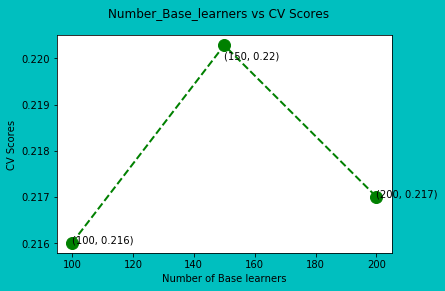

the misclassification error for each Base learners is :  [0.216   0.22029 0.217  ]


In [99]:
Optimal_Depth_Tree1=Optimal_Base_learners(final_tfidf_np,Train_data)


#### Base_learners graph with different depth size

[0.77380952 0.77152381 0.77504762 0.78571429 0.78690476 0.78771429
 0.77733333 0.77666667 0.77852381]
[8, 14, 18]
[8, 14, 18]
[8, 14, 18]


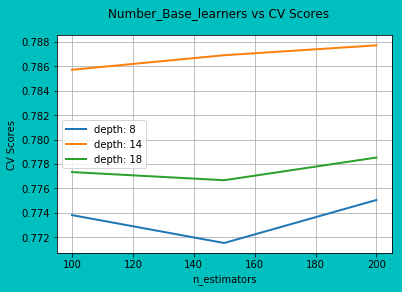

In [100]:
clf_perform_depth(random_forest,final_tfidf_np ,Train_data)

## Random Forest for optimal Parametersusing TF-IDF 

In [218]:
print("Best Parameters for Random Forest is ",optimal_parameters_RF)
Best_criterion=optimal_parameters_RF.get('criterion')
Best_max_features=optimal_parameters_RF.get('max_features')
Best_n_estimators=optimal_parameters_RF.get('n_estimators')
Best_max_depth=optimal_parameters_RF.get('max_depth')

Best Parameters for Random Forest is  {'criterion': 'gini', 'max_depth': 14, 'max_features': 'sqrt', 'n_estimators': 150}


In [219]:

RF_clf4 = RandomForestClassifier(n_estimators=Best_n_estimators,max_depth=Best_max_depth,criterion=Best_criterion,
                                max_features=Best_max_features, random_state=0,n_jobs=-1)
RF_clf4.fit(final_tfidf_np,Train_data)
RF4=RF_clf4.fit(final_tfidf_np,Train_data)


In [220]:
prediction4= RF_clf4.predict(final_tfidf_np_test)

In [221]:
#Training accuracy and training error
training_score=RF_clf4.score(final_tfidf_np,Train_data)
print('training accuracy=',training_score)
training_error=1-training_score
print('training error is =',training_error)

training accuracy= 0.9704642857142857
training error is = 0.029535714285714332


In [222]:
# Testing Accuracy and testing error for Random Forest model

Testing_score=round(accuracy_score(y_test_new ,prediction4),5)
print("Accuracy for Random Forest model with TF-IDF is = ",Testing_score)
Testing_error=1-Testing_score
print("Testing error for Random Forest model with TF-IDF  is = ",Testing_error)

Accuracy for Random Forest model with TF-IDF is =  0.67383
Testing error for Random Forest model with TF-IDF  is =  0.32616999999999996


In [223]:
F1_score = round(f1_score(y_test_new ,prediction4,average='macro'),5)*100
recall = round(recall_score(y_test_new,prediction4,average='macro'),5)*100
precision = round(precision_score(y_test_new ,prediction4,average='macro'),5)*100

In [224]:
print(classification_report( y_test_new,prediction4))

             precision    recall  f1-score   support

          0       0.50      0.07      0.12      3917
          1       0.68      0.97      0.80      8083

avg / total       0.62      0.67      0.58     12000



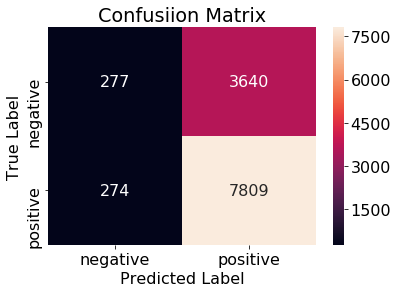

In [225]:
cm = confusion_matrix(y_test_new,prediction4)
label = ['negative', 'positive']
df_conf = pd.DataFrame(cm, index = label, columns = label)
sns.heatmap(df_conf, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### ROC_AUC_plot

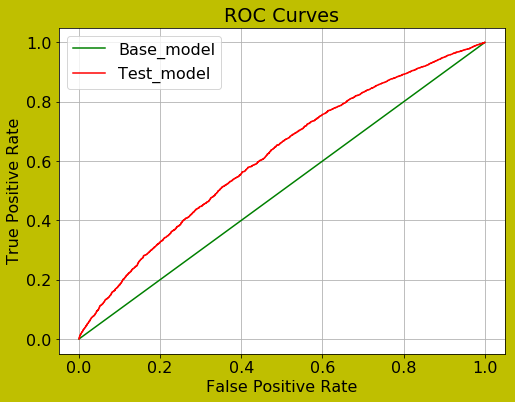

AUC: 0.6125867945695272


In [226]:
roc_auc_plot(RF_clf4,y_test_new,final_tfidf_np_test)

In [227]:
models_performence1['Model'].append('Random Forest')
models_performence1['Vectorizer'].append('TF-IDF ')
models_performence1['Optimal_Base_learners'].append(Best_n_estimators)
models_performence1['Best_criterion'].append(Best_criterion)
models_performence1['Best_max_features'].append(Best_max_features)
models_performence1['Best_max_depth'].append(Best_max_depth)
models_performence1['Training error'].append(training_error)
models_performence1[ 'Test error'].append(Testing_error)
models_performence1[ 'Accuracy'].append(Testing_score)
models_performence1[ 'F1'].append(F1_score)
models_performence1['recall'].append(recall)
models_performence1[ 'precision'].append(precision)

In [228]:
columns = ["Model","Vectorizer", "Optimal_Base_learners","Best_criterion","Best_max_features",
           "Best_max_depth","Training error",  "Test error",
            "Accuracy","F1","recall","precision",
          ]
df7=pd.DataFrame(models_performence1, columns=columns)
result_display(df7)

|    Model    |       Vectorizer       |Optimal_Base_learners|Best_criterion|Best_max_features|Best_max_depth|Training error|Test error|Accuracy| F1  |recall|precision|
|-------------|------------------------|--------------------:|--------------|-----------------|-------------:|-------------:|---------:|-------:|----:|-----:|--------:|
|Random Forest|Avg word2vec            |                  150|gini          |sqrt             |            14|       0.02139|    0.1942|  0.8058|75.77| 74.04|    80.02|
|Random Forest|TF-IDF weighted word2vec|                  200|gini          |log2             |            14|       0.02818|    0.2222|  0.7778|71.07| 69.42|    77.55|
|Random Forest|BOW                     |                  150|gini          |log2             |             8|       0.26225|    0.3178|  0.6822|43.42| 51.43|    77.52|
|Random Forest|TF-IDF                  |                  150|gini          |sqrt             |            14|       0.02954|    0.3262|  0.6738|46.18| 51.

## Observation

|    Model    |       Vectorizer       |Optimal_Base_learners|Best_criterion|Best_max_features|Best_max_depth|Training error|Test error|Accuracy| F1  |recall|precision|
|-------------|------------------------|--------------------:|--------------|-----------------|-------------:|-------------:|---------:|-------:|----:|-----:|--------:|
|Random Forest|Avg word2vec            |                  150|gini          |sqrt             |            14|       0.02139|    0.1942|  0.8058|75.77| 74.04|    80.02|
|Random Forest|TF-IDF weighted word2vec|                  200|gini          |log2             |            14|       0.02818|    0.2222|  0.7778|71.07| 69.42|    77.55|
|Random Forest|BOW                     |                  150|gini          |log2             |             8|       0.26225|    0.3178|  0.6822|43.42| 51.43|    77.52|
|Random Forest|TF-IDF                  |                  150|gini          |sqrt             |            14|       0.02954|    0.3262|  0.6738|46.18| 51.84|    59.24|


* For given  Random Forest model, AUC is 0.612.
* TPR & FPR is high while TNR &FNR is quite low.
*  the result obtained from Random Forest using TF_IDF is quite low comparatively to other random forest models.

## Optimal Base_learners,depth size & Learning Rate using TF_IDF

Optimal_estim_GBDT=== XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=8, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

The optimal parameter for GBDT is === {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200}


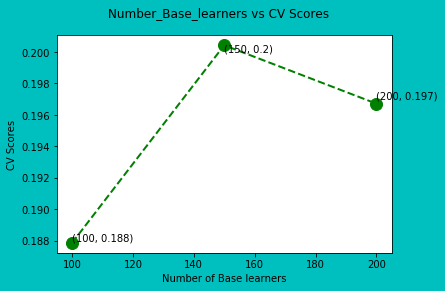

the misclassification error for each Base learners is :  [0.18786 0.20043 0.19671]


In [102]:
warnings.filterwarnings("ignore")
Optimal_BL_Depth_LR(final_tfidf_np,Train_data)


#### Base_learners graph with different depth size

[0.8037619  0.80657143 0.8072381  0.80061905 0.8032381  0.80433333
 0.80004762 0.80347619 0.805     ]
[8, 14, 18]
[8, 14, 18]
[8, 14, 18]


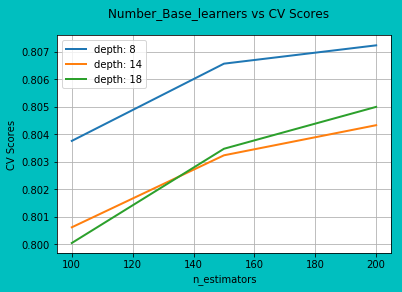

In [103]:

clf_perform_depth(GBDT_model,final_tfidf_np,Train_data)

## GBDT Model for optimal Parameters

In [54]:
print("Best Parameters for GBDT is ",Optimal_param_GBDT)

Best_learning_rate=Optimal_param_GBDT.get('learning_rate')
Best_n_estimators=Optimal_param_GBDT.get('n_estimators')
Best_max_depth=Optimal_param_GBDT.get('max_depth')

Best Parameters for GBDT is  {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200}


3it [00:00, 155.77it/s]


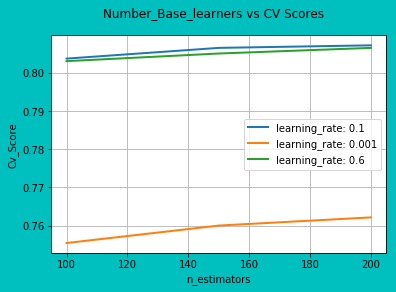

In [105]:
GBDT_LR(Best_max_depth,final_tfidf_np ,Train_data)

In [55]:
# GBDT classifier for optimal parametrs
GBDT_clf14 = XGBClassifier(n_estimators=Best_n_estimators,learning_rate=Best_learning_rate,
                                max_depth=Best_max_depth,scoring="sqrt",
                          n_jobs=-1, cv=tscv, verbose=1)
GBDT_clf14.fit(final_tfidf_np, Train_data)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1,
       cv=TimeSeriesSplit(max_train_size=None, n_splits=3), gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=None, n_estimators=200, n_jobs=-1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, scoring='sqrt',
       seed=None, silent=True, subsample=1, verbose=1)

In [232]:
prediction14= GBDT_clf14.predict(final_tfidf_np_test)

In [233]:
#Training accuracy and training error
training_score=GBDT_clf14.score(final_tfidf_np,Train_data)
print('training accuracy=',training_score)
training_error=1-training_score
print('training error is =',training_error)

training accuracy= 0.9987857142857143
training error is = 0.0012142857142857233


In [234]:
# Testing Accuracy and testing error for GBDT model
Testing_score=round(accuracy_score(y_test_new ,prediction14),5)
print("Accuracy for GBDT model with Avg word2vec is = ",Testing_score)
Testing_error=1-Testing_score
print("Testing error for GBDT model with Avg word2vec is = ",Testing_error)

Accuracy for GBDT model with Avg word2vec is =  0.66175
Testing error for GBDT model with Avg word2vec is =  0.33825000000000005


In [235]:
# Testing Accuracy and testing error for GBDT model
Testing_score=round(accuracy_score(y_test_new ,prediction12),5)
print("Accuracy for GBDT model with TF-IDF is = ",Testing_score)
Testing_error=1-Testing_score
print("Testing error for GBDT model with TF-IDF is = ",Testing_error)

Accuracy for GBDT model with TF-IDF is =  0.79575
Testing error for GBDT model with TF-IDF is =  0.20425000000000004


In [236]:
F1_score = round(f1_score(y_test_new ,prediction14,average='macro'),5)*100
recall = round(recall_score(y_test_new,prediction14,average='macro'),5)*100
precision = round(precision_score(y_test_new ,prediction14,average='macro'),5)*100

In [237]:
print(classification_report(y_test_new,prediction14))

             precision    recall  f1-score   support

          0       0.46      0.20      0.28      3917
          1       0.70      0.89      0.78      8083

avg / total       0.62      0.66      0.62     12000



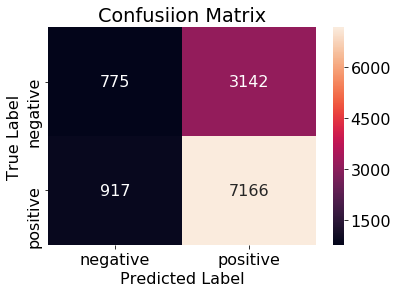

In [238]:
cm = confusion_matrix(y_test_new ,prediction14)
label = ['negative', 'positive']
df_conf = pd.DataFrame(cm, index = label, columns = label)
sns.heatmap(df_conf, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### ROC_AUC_plot

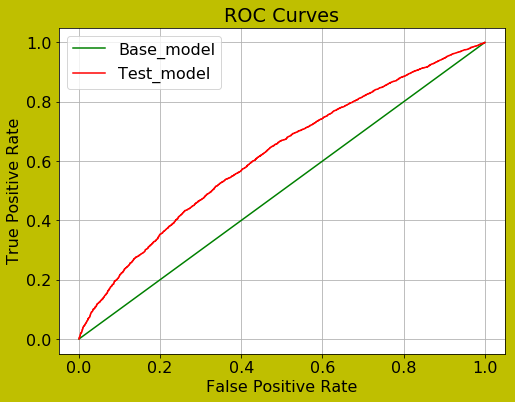

AUC: 0.619135317140324


In [239]:
roc_auc_plot(GBDT_clf14,y_test_new,final_tfidf_np_test)

In [240]:
models_performence['Model'].append('GBDT')
models_performence['Vectorizer'].append('TF-IDF ')
models_performence['Optimal_Base_learners'].append(Best_n_estimators)
models_performence['Best_learning_rate'].append(Best_learning_rate)
models_performence['Best_max_depth'].append(Best_max_depth)
models_performence['Training error'].append(training_error)
models_performence[ 'Test error'].append(Testing_error)
models_performence[ 'Accuracy'].append(Testing_score)
models_performence[ 'F1'].append(F1_score)
models_performence['recall'].append(recall)
models_performence[ 'precision'].append(precision)

In [241]:
columns = ["Model","Vectorizer", "Optimal_Base_learners","Best_learning_rate","Best_max_depth",
          "Training error",  "Test error",
            "Accuracy","F1","recall","precision",
          ]
df8=pd.DataFrame(models_performence, columns=columns)
result_display(df8)

|Model|       Vectorizer       |Optimal_Base_learners|Best_learning_rate|Best_max_depth|Training error|Test error|Accuracy| F1  |recall|precision|
|-----|------------------------|--------------------:|-----------------:|-------------:|-------------:|---------:|-------:|----:|-----:|--------:|
|GBDT |Avg word2vec            |                  200|               0.1|            14|      0.000071|    0.1821|  0.8179|78.24| 77.06|    80.20|
|GBDT |TF-IDF weighted word2vec|                  200|               0.1|             8|      0.005250|    0.2043|  0.7957|75.29| 74.04|    77.68|
|GBDT |BOW                     |                  200|               0.1|             8|      0.002000|    0.2262|  0.7738|71.62| 70.20|    75.63|
|GBDT |TF-IDF                  |                  200|               0.1|             8|      0.001214|    0.2043|  0.7957|52.78| 54.22|    57.66|



## Observation

|Model|       Vectorizer       |Optimal_Base_learners|Best_learning_rate|Best_max_depth|Training error|Test error|Accuracy| F1  |recall|precision|
|-----|------------------------|--------------------:|-----------------:|-------------:|-------------:|---------:|-------:|----:|-----:|--------:|
|GBDT |Avg word2vec            |                  200|               0.1|            14|      0.000071|    0.1821|  0.8179|78.24| 77.06|    80.20|
|GBDT |TF-IDF weighted word2vec|                  200|               0.1|             8|      0.005250|    0.2043|  0.7957|75.29| 74.04|    77.68|
|GBDT |BOW                     |                  200|               0.1|             8|      0.002000|    0.2262|  0.7738|71.62| 70.20|    75.63|
|GBDT |TF-IDF                  |                  200|               0.1|             8|      0.001214|    0.2043|  0.7957|52.78| 54.22|    57.66|

* For given GBDT model ,ROC curve is shown in graph and AUC is 0.619.
* The model variations with different depth size & learning rate can be seen Score Vs base learners graph.
* TPR & FPR is high while FNR & TNR is low as seen in confusion matrix.
* The results obtained from GBDT model using TF_IDF is quite low comparatively other GBDT models.

# Feature Importance for Random Forest

In [56]:
# top_feats is function to get feature importance and print it
def top_feats(row, features, top_n=15):
    topn_ids = np.argsort(row)[::-1][:top_n]
    names = np.array(features)
    print(names[topn_ids])
    top_feats = [(features[i], row[i]) for i in topn_ids]
    global df_feat
    df_feat = pd.DataFrame(top_feats,names[topn_ids])
    df_feat.columns = ['FEATURE', 'Feat_IMP_value']
    
    return df_feat

## Feature importance using count_vect

### Feature importance for Random Forest 

In [243]:
data=count_vect.fit_transform(X_train_data.values.ravel())

RF_clf311= RandomForestClassifier(n_estimators=100,max_depth=8,criterion='gini',
                                max_features='sqrt', random_state=0,n_jobs=-1)


In [244]:
RF_clf311.fit(data ,y_train_new)
# Calculate feature importances
count_vect_feature=count_vect.get_feature_names()

feature_importance =RF_clf311.feature_importances_
print(feature_importance)

[0. 0. 0. ... 0. 0. 0.]


In [245]:
top_feat = top_feats(feature_importance,count_vect_feature,15)
result_display(top_feat)

['great' 'disappoint' 'love' 'delici' 'money' 'thought' 'wast' 'product'
 'best' 'aw' 'favorit' 'receiv' 'threw' 'contact' 'stale']
| FEATURE  |Feat_IMP_value|
|----------|-------------:|
|great     |       0.03758|
|disappoint|       0.03291|
|love      |       0.02407|
|delici    |       0.02141|
|money     |       0.02023|
|thought   |       0.01517|
|wast      |       0.01284|
|product   |       0.01283|
|best      |       0.01243|
|aw        |       0.01213|
|favorit   |       0.01187|
|receiv    |       0.01177|
|threw     |       0.01115|
|contact   |       0.01067|
|stale     |       0.01039|



Text(0,0.5,'Relative Feature Importance  ')

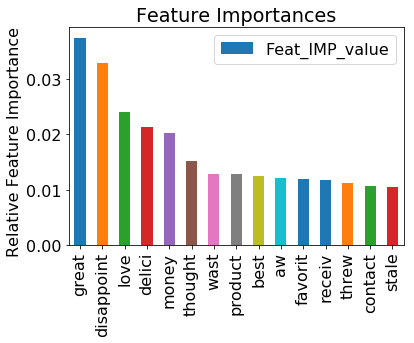

In [246]:
df_feat.plot.bar(y='Feat_IMP_value',title='Feature Importances', rot=90)
plt.ylabel('Relative Feature Importance  ')

### Feature importance for GBDT

In [247]:
GBDT_clf1311 = XGBClassifier(n_estimators=100,
                           learning_rate=0.1,
                            max_depth=8,
                           scoring="sqrt",
                          n_jobs=-1, cv=tscv, verbose=1)

In [248]:
GBDT_clf1311.fit(data ,y_train_new)
# Calculate feature importances
count_vect_feature=count_vect.get_feature_names()
feature_importance =GBDT_clf1311.feature_importances_

['tast' 'product' 'like' 'one' 'good' 'tri' 'flavor' 'would' 'use' 'great'
 'get' 'love' 'food' 'dont' 'make']
|FEATURE|Feat_IMP_value|
|-------|-------------:|
|tast   |      0.026613|
|product|      0.024357|
|like   |      0.023455|
|one    |      0.020147|
|good   |      0.018193|
|tri    |      0.014584|
|flavor |      0.014584|
|would  |      0.014133|
|use    |      0.012930|
|great  |      0.010224|
|get    |      0.010224|
|love   |      0.009472|
|food   |      0.008269|
|dont   |      0.008119|
|make   |      0.007818|



Text(0,0.5,'Relative Feature Importance ')

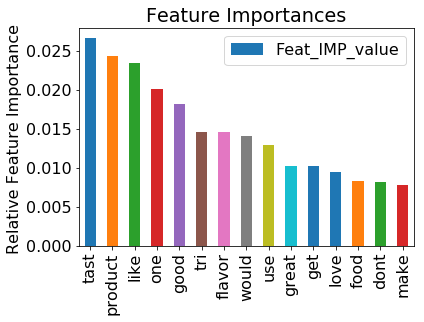

In [249]:
top_feat = top_feats(feature_importance,count_vect_feature,15)
result_display(top_feat)
df_feat.plot.bar(y='Feat_IMP_value',title='Feature Importances', rot=90)
plt.ylabel('Relative Feature Importance ')

## Feature importance using tf-idf -vect

### Feature importance for Random Forest 

In [250]:
final_tf_idf11 = tf_idf_vect.fit_transform(X_train_data.values.ravel())

In [251]:
RF_clf411 = RandomForestClassifier(n_estimators=100,max_depth=8,criterion='gini',
                                max_features=Best_max_features, random_state=0,n_jobs=-1)


In [252]:

RF_clf411.fit(final_tf_idf11 ,y_train_new)
tf_idf_feature=tf_idf_vect .get_feature_names()
feature_importance1 = RF_clf411.feature_importances_


['refund' 'great' 'wast' 'threw' 'product' 'sent' 'add' 'never buy'
 'receiv' 'bad' 'keep' 'alway' 'best' 'wors' 'dont wast']
| FEATURE |Feat_IMP_value|
|---------|-------------:|
|refund   |      0.015622|
|great    |      0.013658|
|wast     |      0.013036|
|threw    |      0.010216|
|product  |      0.009257|
|sent     |      0.008865|
|add      |      0.008831|
|never buy|      0.008272|
|receiv   |      0.007820|
|bad      |      0.007629|
|keep     |      0.007416|
|alway    |      0.007394|
|best     |      0.007390|
|wors     |      0.007251|
|dont wast|      0.007171|



Text(0,0.5,'Relative Feature Importance  ')

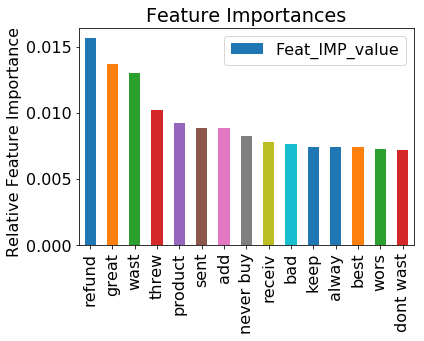

In [253]:
# Relative Feature Importance  using tf_idf
top_feat1 = top_feats(feature_importance1,tf_idf_feature,15)
result_display(top_feat1)
df_feat.plot.bar(y='Feat_IMP_value',title='Feature Importances', rot=90)
plt.ylabel('Relative Feature Importance  ')

### Feature importance for GBDT 

In [254]:
GBDT_clf1411 = XGBClassifier(n_estimators=Best_n_estimators,learning_rate=Best_learning_rate,
                                max_depth=Best_max_depth,scoring="sqrt",
                          n_jobs=-1, cv=tscv, verbose=1)

In [255]:

GBDT_clf1411.fit(final_tf_idf11 ,Train_data)
tf_idf_feature=tf_idf_vect .get_feature_names()
feature_importance1 =GBDT_clf1411.feature_importances_


['tast' 'like' 'product' 'good' 'one' 'tri' 'great' 'love' 'would' 'get'
 'flavor' 'use' 'best' 'much' 'buy']
|FEATURE|Feat_IMP_value|
|-------|-------------:|
|tast   |      0.033450|
|like   |      0.025605|
|product|      0.021355|
|good   |      0.020484|
|one    |      0.016670|
|tri    |      0.016343|
|great  |      0.015145|
|love   |      0.014164|
|would  |      0.013511|
|get    |      0.013184|
|flavor |      0.012639|
|use    |      0.009697|
|best   |      0.008825|
|much   |      0.008390|
|buy    |      0.008172|



Text(0,0.5,'Relative Feature Importance  ')

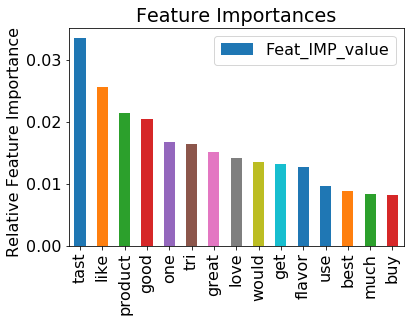

In [256]:
# Relative Feature Importance  using tf_idf
top_feat1 = top_feats(feature_importance1,tf_idf_feature,15)
result_display(top_feat1)
df_feat.plot.bar(y='Feat_IMP_value',title='Feature Importances', rot=90)
plt.ylabel('Relative Feature Importance  ')

### Random Forest Tree Image with all vectorization method

In [257]:
Classifier2=[RF1,RF2,RF3,RF4]

In [258]:
features2=tfidf_feat[:100]

In [259]:
name_png_format2=['RFAvg word2vec.png','RFTF-IDF weighted word2vec.png','RFBOW_Decision_Tree.png','RFTF-IDF.png']

In [260]:
 for i in tqdm(range(4)):
    
    tree_image(Classifier2[i].estimators_[0],features2,name_png_format2[i])

100%|██████████| 4/4 [02:27<00:00, 36.84s/it]


### GBDT Image with all vectorization method

In [57]:
Classifier1=[GBDT_clf1,GBDT_clf12,GBDT_clf13,GBDT_clf14]

In [60]:
features1=tfidf_feat[:100]

In [61]:
name_png_format1=['GBDTAvg word2vec.png','GBDTTF-IDF weighted word2vec.png','GBDTBOW_Decision_Tree.png','GBDTTF-IDF.png']

  0%|          | 0/4 [00:00<?, ?it/s]dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.68076 to fit


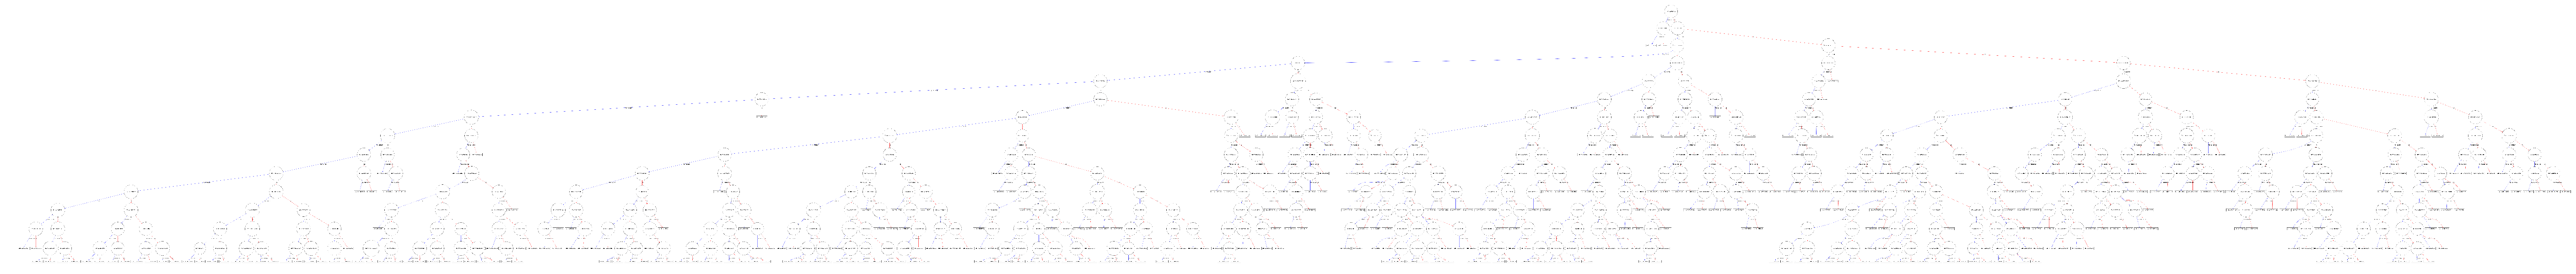

 25%|██▌       | 1/4 [00:37<01:53, 37.85s/it]

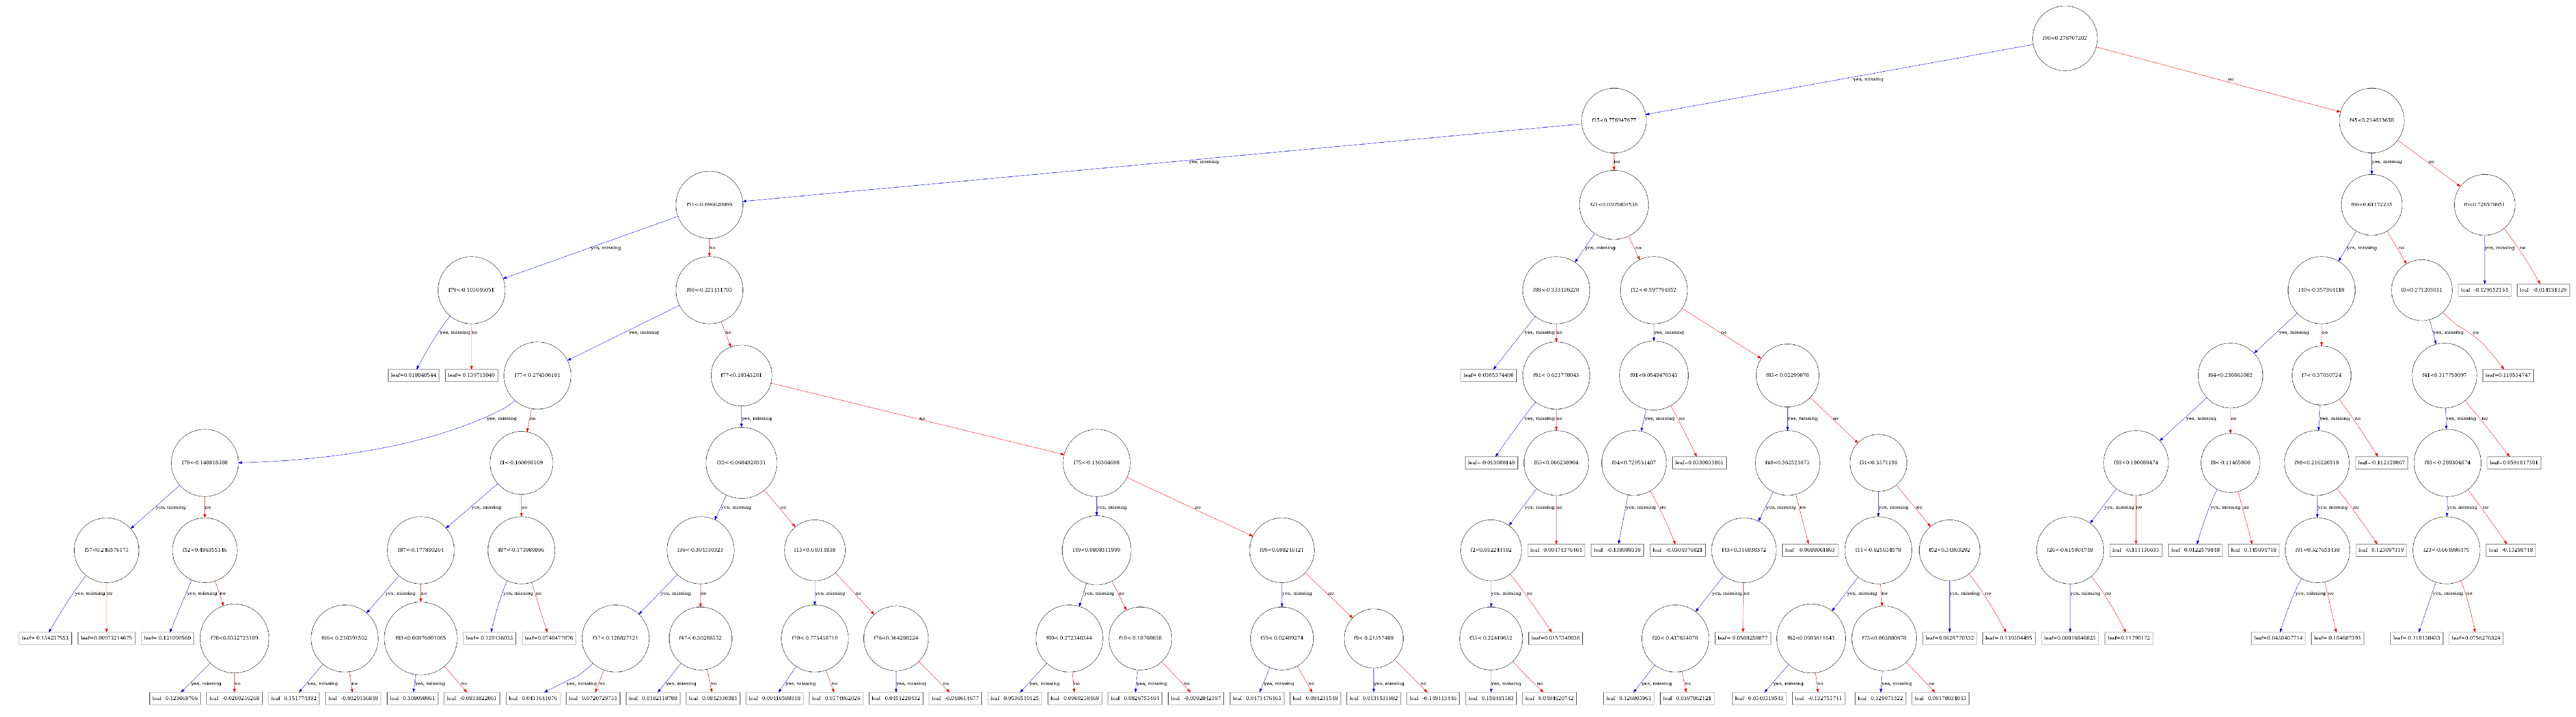

 50%|█████     | 2/4 [00:59<00:59, 29.92s/it]dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.88932 to fit


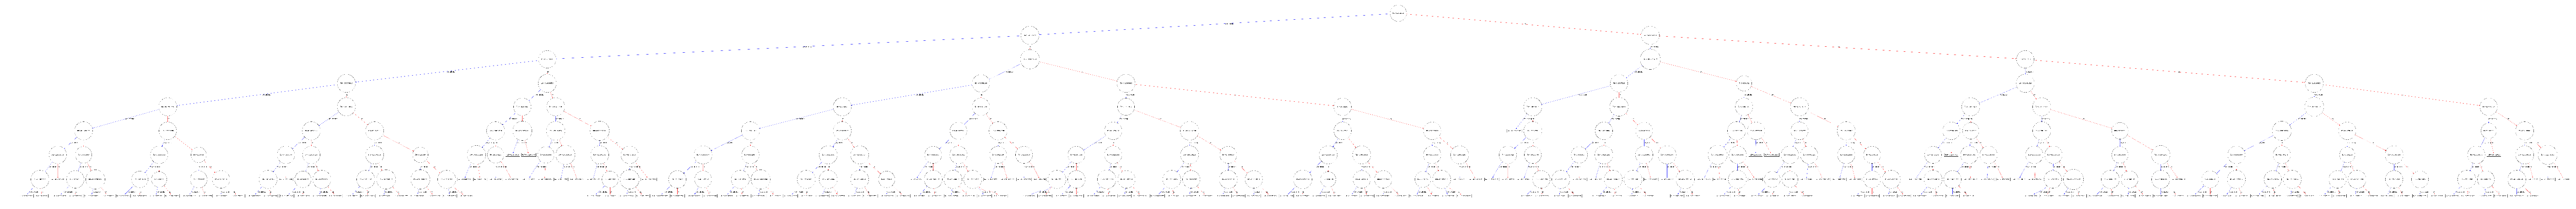

 75%|███████▌  | 3/4 [01:32<00:30, 30.80s/it]

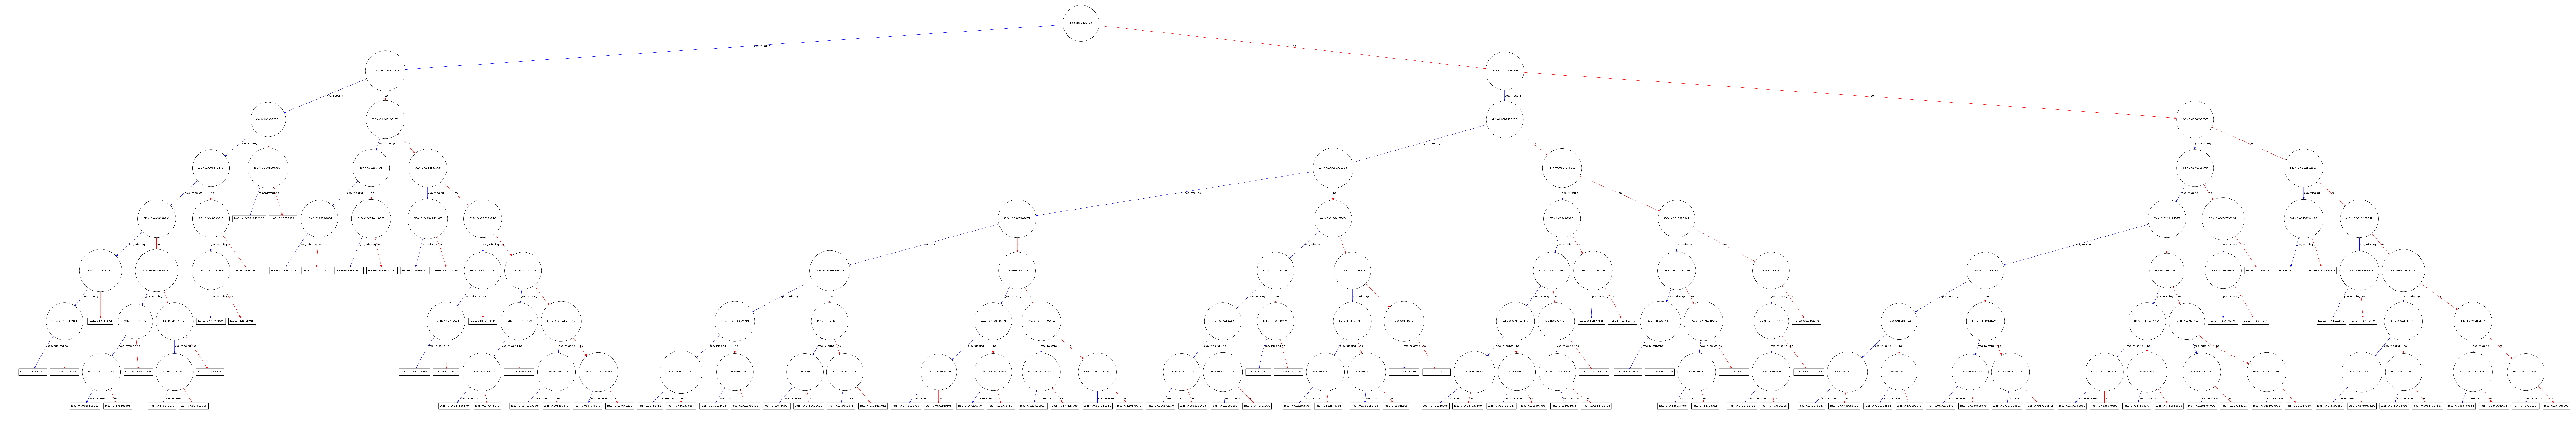

100%|██████████| 4/4 [01:58<00:00, 29.73s/it]


In [62]:
for i in tqdm(range(4)):
    
    fig, ax = plt.subplots(figsize=(100, 100))
    fif=plot_tree(Classifier1[i],num_trees=4, ax=ax)
    plt.savefig(name_png_format1[i])
    plt.show()

# Observation



|    Model    |       Vectorizer       |Optimal_Base_learners|Best_criterion|Best_max_features|Best_max_depth|Training error|Test error|Accuracy| F1  |recall|precision|
|-------------|------------------------|--------------------:|--------------|-----------------|-------------:|-------------:|---------:|-------:|----:|-----:|--------:|
|Random Forest|Avg word2vec            |                  150|gini          |sqrt             |            14|       0.02139|    0.1942|  0.8058|75.77| 74.04|    80.02|
|Random Forest|TF-IDF weighted word2vec|                  200|gini          |log2             |            14|       0.02818|    0.2222|  0.7778|71.07| 69.42|    77.55|
|Random Forest|BOW                     |                  150|gini          |log2             |             8|       0.26225|    0.3178|  0.6822|43.42| 51.43|    77.52|
|Random Forest|TF-IDF                  |                  150|gini          |sqrt             |            14|       0.02954|    0.3262|  0.6738|46.18| 51.84|    59.24|





|Model|       Vectorizer       |Optimal_Base_learners|Best_learning_rate|Best_max_depth|Training error|Test error|Accuracy| F1  |recall|precision|
|-----|------------------------|--------------------:|-----------------:|-------------:|-------------:|---------:|-------:|----:|-----:|--------:|
|GBDT |Avg word2vec            |                  200|               0.1|            14|      0.000071|    0.1821|  0.8179|78.24| 77.06|    80.20|
|GBDT |TF-IDF weighted word2vec|                  200|               0.1|             8|      0.005250|    0.2043|  0.7957|75.29| 74.04|    77.68|
|GBDT |BOW                     |                  200|               0.1|             8|      0.002000|    0.2262|  0.7738|71.62| 70.20|    75.63|
|GBDT |TF-IDF                  |                  200|               0.1|             8|      0.001214|    0.2043|  0.7957|52.78| 54.22|    57.66|

* The results obtained for Random Forest & GBDT model is shown in above table respectively.
* The Model performance with different depth size and learning rate is plotted in Score Vs Number of base learners graph.
* The ROC_AUC graph shows the actual performance of model.
* From the observation,It can be concluded that  Random Forest model &  GBDT  model using  Avg word2vec is best comapartively other models. And Random Forest Model & GBDT model Using TF_IDF performs bad.